<a href="https://colab.research.google.com/github/pramodith/llm_exploration/blob/bert_sparse_attention_training/bert_sparse_attention_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the affects of custom Sparse Attention
In our prior notebook, we found that both encoder-only and decoder-only models offload a significant portion of their attention scores to **sink tokens**. We identified that these sink tokens tend to be either special tokens like **[CLS], [SEP]** or tokens corresponding to **punctuations**. The consistence display of this phenomenon across model architectures and inputs makes one question the relevance of dense self-attention.

In this notebook we'll explore the performance of BERT by creating custom attention masks, which will be sparse in nature. We'll create a unique mask per each token, where all tokens attend to special tokens and the k tokens in their neighborhood. When visualized the tokens along a diagonal of size 2*k+1 and the first anad last tokens (in the case of BERT) being attended to. We'll also explore the effects of allowing dense attention in some layers and sparse attention in the rest.

We'll assess the downstream performance of the models that leverage this type of custom attention mask on some commonly used datasets for benchmarking like [TBD]. Our resulting article can be found [here](https://medium.com/towards-artificial-intelligence/comparing-dense-attention-vs-sparse-sliding-window-attention-6cd5b2e7420f).

In [113]:
%pip install transformers
%pip install datasets
%pip install accelerate -U
%pip install scikit-learn
%pip install overrides
%pip install evaluate
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [114]:
# Importing libraries
from functools import partial
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling
from datasets import load_dataset, load_from_disk, Dataset, Metric
from transformers import TrainingArguments, Trainer,logging
from evaluate import load
import torch
import numpy as np


from transformers import BertModel, BertForSequenceClassification, BertForMaskedLM
from transformers.models.bert.modeling_bert import BertEncoder, logger
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
from transformers.modeling_utils import ModuleUtilsMixin, warnings
from typing import Any, Dict, Optional, Tuple, Union, List
from overrides import overrides
from torch import Tensor
from torch.nn.functional import pad
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt


In [115]:
# Defining the model, tokenizer and dataset
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
sample_text = "Every night I lie in bed."

### Get Dataset Splits and Metrics to Evaluate Model Performance


In [43]:
def get_dataset(dataset_name: str, subset_name: Optional[str]) -> Tuple[Dataset, Dataset, Dataset, List]:
    """
    This function loads the dataset for a given task and splits it into train, dev and test sets. 
    It also returns the number of labels in the dataset.
    
    Args:
        glue_task_name (str): The name of the task to be loaded.

    Returns:
        Tuple[Dataset, Dataset, Dataset, List]: The train, dev, test datasets and a list of the sizes of the training sets.
    """

    # Load the dataset and metric
    dataset = load_dataset(dataset_name, subset_name)
    # Split the dataset
    train_dataset = dataset["train"]
    if "validation" not in dataset or "test" not in dataset:
        split = train_dataset.train_test_split(test_size=0.1)
        if "validation" not in dataset:
            dev_dataset = split["test"]
            test_dataset = dataset["test"]
        elif "test" not in dataset:
            dev_dataset = dataset["validation"]
            test_dataset = split["test"]
    else:
        print(f"{dataset_name} has already been split into train, dev and test sets.")
        dev_dataset = dataset['validation']
        test_dataset = dataset['test']

    # Print a description of the dataset
    print("Dataset Description: ", train_dataset.description)

    # Truncate the dataset if it is too large
    if train_dataset.num_rows > 30000:
        train_dataset = train_dataset.select(range(30000))

    # Print the label space
    print("Label Space: ", train_dataset.features["label"].names)
    num_labels = len(train_dataset.features["label"].names)
    return train_dataset, dev_dataset, test_dataset, num_labels

In [44]:
metrics = [load('accuracy'), load("f1"), load("precision"), load("recall")]

# Accumulate all the datasets
dataset_names = [("dair-ai/emotion",""),("ag_news",""),("tweet_eval","offensive")]
train_datasets, dev_datasets, test_datasets, num_labels, train_datasets_size = [], [], [], [], []
for dataset_name, subset_name in dataset_names:
    train_dataset, dev_dataset, test_dataset, num_label = get_dataset(dataset_name, subset_name)
    train_datasets.append(train_dataset)
    dev_datasets.append(dev_dataset)
    test_datasets.append(test_dataset)
    num_labels.append(num_label)
    train_datasets_size.append(train_dataset.num_rows)

dair-ai/emotion has already been split into train, dev and test sets.
Dataset Description:  Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper.

Label Space:  ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Dataset Description:  AG is a collection of more than 1 million news articles. News articles have been
gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
activity. ComeToMyHead is an academic news search engine which has been running
since July, 2004. The dataset is provided by the academic comunity for research
purposes in data mining (clustering, classification, etc), information retrieval
(ranking, search, etc), xml, data compression, data streaming, and any other
non-commercial activity. For more information, please refer to the link
http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic 

In [45]:
def compute_metrics(eval_pred: Tuple) -> Dict:
    """
    This function computes the metrics for the given task and is used by the Trainer class for evaluation.
    """
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    results = {}
    for metric in metrics:
      if metric.name != "accuracy":
        # Macro averaging for all metrics except accuracy
        results.update(metric.compute(predictions=predictions, references=labels, average="macro"))
      else:
        results.update(metric.compute(predictions=predictions, references=labels))
    return results

## Create Custom Bert Model to support 4-D attention masks
HF doesn't support custom layerwise attention masks. By default it assumes that all layers use the same attention mask. However, we want to be able to experiment with using sparse attention in all the layers but also a hybrid of dense and sparse self attention split across layers.

In order to support this functionality we'll need to override some functions and create Custom Bert Models.

First we'll override the `forward` function of `BertEncoder` to accept 5-d attention masks. The 5-d mask corresponds to (Layer, Batch Size, Attention Head, Sequence length (from token), Sequence length (to token)). We assume that all attention heads share the same attention mask in this notebook.

We highlight the places where we've made some modifications using the comment __Code added here__

In [46]:
class CustomBertEncoder(BertEncoder):
    def __init__(self, config):
        super().__init__(config)

    @overrides
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        attention_mask_is_layerwise = False

        # Code added here
        if attention_mask.dim() == 5:
            attention_mask_is_layerwise = True

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            # Code added here
            if attention_mask_is_layerwise:
               attention_mask_to_use = attention_mask[i]
            else:
                attention_mask_to_use = attention_mask

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    attention_mask_to_use,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask_to_use,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


Next we'll override `get_extended_attention_mask` of the `BertModel` class to create a new dimension expanding 4-d attention masks to 5-d attention masks. The expanded dimension corresponds to attention heads as mentioned above since we assume that all attention heads use the same mask we just need to add a new dimension to the mask tensor.

In [47]:
class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = CustomBertEncoder(config)

    @overrides
    def get_extended_attention_mask(
        self, attention_mask: Tensor, input_shape: Tuple[int], device: torch.device = None, dtype: torch.float = None
    ) -> Tensor:
        """
        Makes broadcastable attention and causal masks so that future and masked tokens are ignored.

        Arguments:
            attention_mask (`torch.Tensor`):
                Mask with ones indicating tokens to attend to, zeros for tokens to ignore.
            input_shape (`Tuple[int]`):
                The shape of the input to the model.

        Returns:
            `torch.Tensor` The extended attention mask, with a the same dtype as `attention_mask.dtype`.
        """
        if dtype is None:
            dtype = self.dtype

        if not (attention_mask.dim() == 2 and self.config.is_decoder):
            # show warning only if it won't be shown in `create_extended_attention_mask_for_decoder`
            if device is not None:
                warnings.warn(
                    "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
                )
        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        # Code added here
        if attention_mask.dim() == 4:
            extended_attention_mask = attention_mask[:, :, None, :, :]
        elif attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
            if self.config.is_decoder:
                extended_attention_mask = ModuleUtilsMixin.create_extended_attention_mask_for_decoder(
                    input_shape, attention_mask, device
                )
            else:
                extended_attention_mask = attention_mask[:, None, None, :]
        else:
            raise ValueError(
                f"Wrong shape for input_ids (shape {input_shape}) or attention_mask (shape {attention_mask.shape})"
            )

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and the dtype's smallest value for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(dtype).min
        return extended_attention_mask


#### Create a custom bert model for sequence classification that uses the custom bert encoder

In [48]:
class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.bert = CustomBertModel(config)

The `DefaultCollatorForMaskedLM` doesn't work with our custom masking scheme, so we create a function to mask the input tokens for the MLM task.

In [116]:
def torch_mask_tokens(tokenizer: AutoTokenizer, mlm_probability: float, inputs: Any, special_tokens_mask: Optional[Any] = None) -> Tuple[Any, Any]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """
    import torch

    labels = inputs.clone()
    # We sample a few tokens in each sequence for MLM training (with probability `self.mlm_probability`)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    if special_tokens_mask is None:
        special_tokens_mask = [
            tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
        ]
        special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
    else:
        special_tokens_mask = special_tokens_mask.bool()

    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

The `custom_tokenize` function is a utility function designed to tokenize text for a transformer model like BERT, with a custom attention mask.

Here's a high-level overview of what it does:

1. **Tokenization**: It uses the provided tokenizer to convert the input text into tokens.

2. **Attention Mask Creation**: It creates a custom attention mask where each token attends to its neighbors within a specified distance. The distance can be adjusted using the `distance` parameter.

3. **Special Tokens**: If `special_tokens_attend_to_all` is set to `True`, the function modifies the attention mask so that the special tokens (CLS and SEP) attend to all tokens and all tokens attend to them.

4. **Batch Mode**: If `batch_mode` is set to `True`, the function adds an extra dimension to the output tensors to accommodate batch processing.

The function returns a dictionary containing the tokenized inputs ('input_ids' and 'token_type_ids') and the custom attention mask.

In [117]:
def custom_tokenize(tokenizer: AutoTokenizer, text: str, distance:int=2, batch_mode=False, special_tokens_attend_to_all: bool = True) -> Dict:
    """
    This function tokenizes the given text and returns the tokenized inputs along with the attention mask.

    Args:
        tokenizer (AutoTokenizer): The tokenizer to be used for tokenization.
        text (str): The text to be tokenized.
        distance (int, optional): The number of neigbhoring tokens that should be attended to.
        batch_mode (bool, optional): If we need to add an extra dimension for batch processing.
        special_tokens_attend_to_all (bool, optional): If the special tokens should attend to all other tokens and 
          all other tokens should attend to the special tokens.

    Returns:
        Dict: The tokenized inputs along with the attention mask.
    """
    # Tokenize the texts
    result = tokenizer(text, truncation=True, padding=False)
    # Create attention mask with ones on the main diagonal
    attention_mask = torch.eye(len(result["input_ids"]), dtype=torch.long)
    # Update attention mask for the specified neighborhood distance
    attention_mask[abs(torch.arange(len(attention_mask))[:, None] - torch.arange(len(attention_mask))) <= distance] = 1

    if special_tokens_attend_to_all:
      # Set the first row to 1 corresponding to the CLS token
      attention_mask[0, :] = 1
      # Always attend to CLS
      attention_mask[:, 0] = 1
      # Set the last row to 1 corresponding to the SEP token
      attention_mask[-1, :] = 1
      # Always attend to SEP
      attention_mask[:, -1] = 1
      # Add the attention mask to the result

    if batch_mode:
      result["attention_mask"] = torch.LongTensor(attention_mask.unsqueeze(0))
      result["input_ids"] = torch.LongTensor(result["input_ids"]).unsqueeze(0)
      result["token_type_ids"] = torch.LongTensor(result["token_type_ids"]).unsqueeze(0)
    else:
      result["attention_mask"] = torch.LongTensor(attention_mask)
      result["input_ids"] = torch.LongTensor(result["input_ids"])
      result["token_type_ids"] = torch.LongTensor(result["token_type_ids"])
    # Map the labels to the tokenized inputs
    return result

Let's make sure our implementation is right by visualizing a heatmap of our attention scores. We should expect to see a sliding window of attention along the diagonal while the **[CLS]** and **[SEP]** tokens are allowed to attend to all tokens and all tokens are allowed to attend to the **[CLS]** and **[SEP]** tokens.

In [51]:
custom_model = CustomBertForSequenceClassification.from_pretrained(model_name)
#inputs = custom_tokenize(tokenizer, sample_text, distance=1, batch_mode=True, special_tokens_attend_to_all=False)
inputs = custom_tokenize(tokenizer, sample_text, distance=1, batch_mode=True)
output = custom_model(**inputs, output_attentions=True)

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


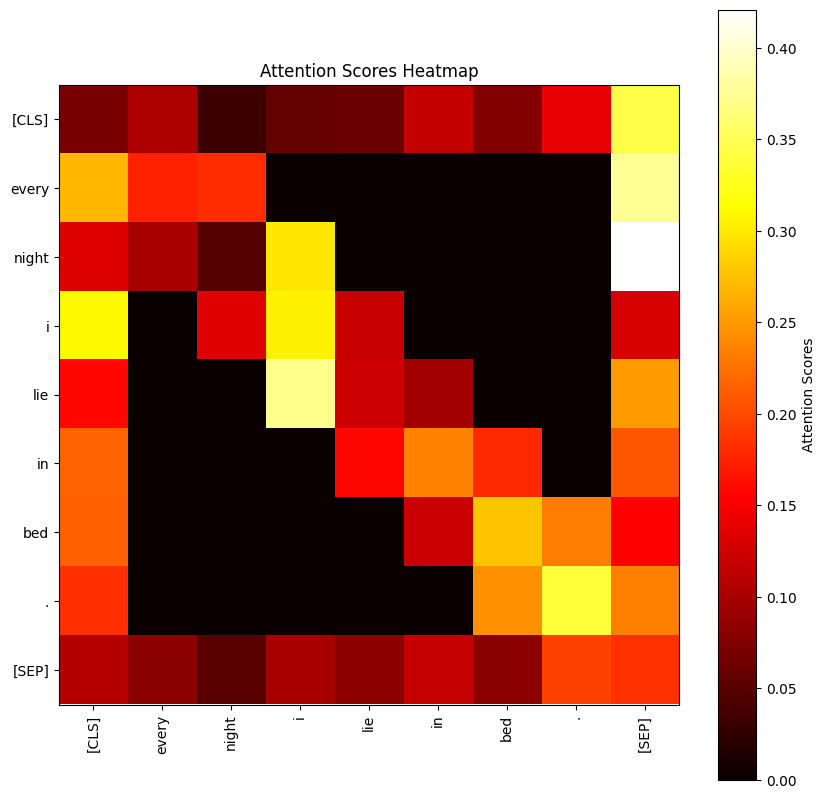

In [52]:
# Get the attention scores for Layer 0, Batch 0, Head 0
attention_scores = output.attentions[0][0,0].detach().numpy()

# Get the tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Create a heatmap
plt.figure(figsize=(10,10))
plt.imshow(attention_scores, cmap='hot', interpolation='nearest')
plt.colorbar(label='Attention Scores')
plt.title('Attention Scores Heatmap')
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.show()

In [53]:
inputs["attention_mask"].shape

torch.Size([1, 9, 9])

Great! That's working, now let's make sure that masking also works when we send in a 4-d tensor. Where dimension 0 is the layer number.

In [54]:
inputs["attention_mask"] = inputs["attention_mask"].unsqueeze(0).repeat(12,1,1,1)
output_layerwise_mask = custom_model(**inputs, output_attentions=True)
assert torch.allclose(output.attentions[0], output_layerwise_mask.attentions[0]), "Attention scores have to be the same for the same attention mask even if it is repeated layerwise"

## Creating Layerwise Attention Masks
The `get_layerwise_attention_mask` function is designed to create a layer-wise attention mask from a given input attention mask. This function is particularly useful when working with transformer models like BERT, where different layers might require different attention masks.

Here are the parameters of the function:

- `attention_mask` (Tensor): This is the input attention mask that you want to convert into a layer-wise attention mask. It should be a tensor.

- `pad_token_pos` (int): This is the position of the padding token in the attention mask. The function uses this to set the range of full attention.

- `total_num_layers` (int, optional): This is the total number of layers in the model. By default, it's set to 12, which is the number of layers in BERT-base models.

- `full_attention_layers` (list, optional): This is a list of layer numbers that should have full attention. By default, it's an empty list, meaning no layers have full attention.

The function returns a tensor which is the layer-wise attention mask. If `full_attention_layers` is not empty, the function repeats the attention mask for each layer and sets full attention for the specified layers.

In [55]:
def get_layerwise_attention_mask(attention_mask: Tensor, pad_token_pos:int, total_num_layers:int=12, full_attention_layers=[]):
  """
  Returns a layer-wise attention mask for a given input attention mask.

  Args:
    attention_mask (Tensor): The input attention mask.
    pad_token_pos (int): The position of the padding token in the attention mask.
    total_num_layers (int, optional): The total number of layers in the model. Defaults to 12.
    full_attention_layers (list, optional): A list of layer numbers that should have full attention. Defaults to [].

  Returns:
    Tensor: The layer-wise attention mask.
  """
  attention_mask = attention_mask.unsqueeze(0)
  if full_attention_layers:
    attention_mask = attention_mask.repeat(total_num_layers, 1, 1, 1)
    for layer_num in full_attention_layers:
      attention_mask[layer_num, :, : pad_token_pos, : pad_token_pos] = 1
  return attention_mask

Let's make sure that this is working as desired.
This test case is validating the `get_layerwise_attention_mask` function. It checks three things:

1. The function returns an attention mask of the correct shape (12, 1, 4, 4).
2. The attention mask at layer 0 is the same as the input mask (all zeros).
3. The attention mask at layer 2 is all ones, indicating full attention.

If any of these conditions are not met, the test case fails.

In [56]:
dummy_attn_mask = torch.zeros(1, 4, 4)
layerwise_attn_mask = get_layerwise_attention_mask(dummy_attn_mask, 4, full_attention_layers=[2])
assert layerwise_attn_mask.shape == (12, 1, 4, 4), f"{layerwise_attn_mask.shape} is the wrong shape"
assert torch.allclose(layerwise_attn_mask[0], dummy_attn_mask), "Masks at layer 0 should all be 0s"
assert torch.allclose(layerwise_attn_mask[2], torch.ones(1,4,4)), "Masks at layer 1 should all be 1s"

## Padding custom attention Masks

The `custom_collate` function is a utility function designed to process a batch of data for training a transformer model like BERT. It performs several key tasks:

1. **Padding**: It pads all sequences in the batch to the same length, using the provided `pad_token_id`.

2. **Layer-wise Attention Mask**: It creates a layer-wise attention mask for each sequence in the batch. This is useful when different layers of the transformer model require different attention masks.

3. **Masked Language Modeling**: If the `is_mlm` flag is set to `True`, it applies masked language modeling to the input sequences. This involves randomly masking some of the tokens in each sequence, with the goal of predicting the original token from its context. The probability of masking a token is controlled by the `mlm_probability` parameter.

The function returns a dictionary containing the padded 'input_ids', the layer-wise 'attention_mask', 'token_type_ids', and 'labels' (if present in the batch).

In [57]:
def custom_collate(batch:List, pad_token_id:int, full_attention_layers:List=[], mlm_probability:float=0.15, is_mlm:bool=False):
  """
  Custom collate function for DataLoader that pads sequences and creates layer-wise attention masks.

  Args:
    batch (list): List of dictionaries containing 'input_ids', 'attention_mask', 'token_type_ids', and optionally 'label'.
    pad_token_id (int): The ID of the padding token.
    full_attention_layers (list, optional): List of layers that should have full attention. Defaults to [].
    mlm_probability (float, optional): Probability of masking a token for masked language modeling. Defaults to 0.15.
    is_mlm (bool, optional): Whether to apply masked language modeling. Defaults to False.

  Returns:
    dict: A dictionary containing 'input_ids', 'attention_mask', 'token_type_ids', and 'labels' (if present in batch).
  """
  input_ids = [torch.LongTensor(batch[i]["input_ids"]) for i in range(len(batch))]
  attention_mask = [torch.LongTensor(batch[i]["attention_mask"]) for i in range(len(batch))]
  token_type_ids = [torch.LongTensor(batch[i]["token_type_ids"]) for i in range(len(batch))]
  if "labels" in batch[0]:
    label = torch.LongTensor([batch[i]["labels"] for i in range(len(batch))])
  #idx = [batch[i]["idx"] for i in range(len(batch))]
  max_len = max([len(inp) for inp in input_ids])
  padding_sizes = [max_len - len(inp) for inp in input_ids]
  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
  token_type_ids = pad_sequence(token_type_ids, batch_first=True)
  attention_mask = [get_layerwise_attention_mask(pad(attention_mask[i], (0, padding_sizes[i], 0, padding_sizes[i]), value=0), padding_sizes[i], full_attention_layers=full_attention_layers).squeeze(1) for i in range(len(batch))]
  attention_mask = torch.stack(attention_mask)
  if full_attention_layers:
    attention_mask = attention_mask.permute(1,0,2,3)
  else:
    attention_mask = attention_mask.squeeze(1)

  if is_mlm:
    input_ids, label = torch_mask_tokens(tokenizer, mlm_probability, input_ids)
  return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "token_type_ids": token_type_ids,
      "labels": label,
  }

In [58]:
custom_collate([{"input_ids":[1,2,3,4], "attention_mask":[[1,1,1,0],[1,1,1,0],[1,1,1,0],[1,1,1,0]], "token_type_ids":[0,0,0,0], "label":1}, {"input_ids":[1,2,3,4,5], "attention_mask":[[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,0]], "token_type_ids":[0,0,0,0,0], "label":1}], tokenizer.pad_token_id, full_attention_layers=[2,4], is_mlm=True)

{'input_ids': tensor([[1, 2, 3, 4, 0],
         [1, 2, 3, 4, 5]]),
 'attention_mask': tensor([[[[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [0, 0, 0, 0, 0]],
 
          [[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0]]],
 
 
         [[[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [0, 0, 0, 0, 0]],
 
          [[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0]]],
 
 
         [[[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [0, 0, 0, 0, 0]],
 
          [[1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0],
           [1, 1, 1, 0, 0]]],
 
 
         [[[1, 1, 1, 0, 0],
           [1, 1, 1,

In [59]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 11916
})

We need to encode the datasets for dense and sparse attention differently since we need to create custom attention masks for the latter. We'll create a custom torch dataset so that all of the tokenization and vectorization happens on demand.

The `CustomDataset` class is a custom PyTorch Dataset used for preparing the data for a transformer model like BERT. Here's a high-level overview of its functionality:

1. **Initialization**: During initialization, it takes in the raw dataset, a tokenizer, a mode (either "sparse" or not), a flag indicating whether to apply masked language modeling (`is_mlm`), and a flag indicating whether special tokens should attend to all tokens (`special_tokens_attend_to_all`).

2. **Length**: The `__len__` method returns the length of the dataset.

3. **Get Item**: The `__getitem__` method processes and returns the data at a given index (`idx`). If the mode is "sparse", it uses the `custom_tokenize` function to tokenize the text and create a custom attention mask. Otherwise, it uses the provided tokenizer to tokenize the text. If `is_mlm` is `False`, it also includes the label in the returned data.

This class is useful for preparing the data for training or evaluating a transformer model, especially when you need to use a custom attention mask or apply masked language modeling.

In [118]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, dataset: Dataset, tokenizer:AutoTokenizer, mode="sparse", is_mlm:bool = False,special_tokens_attend_to_all=True):
        """
        This class is a custom dataset class that tokenizes the text and creates attention masks for the given dataset.

        Args:
            dataset: The dataset to be tokenized.
            tokenizer: The tokenizer to be used for tokenization.
            mode (str, optional): Whether we want to use dense or sparse self-attention. Defaults to "sparse".
            is_mlm (bool, optional): Whether we're training on Masked Language Modeling or not. Defaults to False.
            special_tokens_attend_to_all (bool, optional): Whether special tokens should always be attended to. Defaults to True.
        """
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.mode = mode
        self.is_mlm = is_mlm
        self.special_tokens_attend_to_all = special_tokens_attend_to_all

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      if self.mode == "sparse":
        inputs = custom_tokenize(self.tokenizer, self.dataset[idx]["text"], special_tokens_attend_to_all=self.special_tokens_attend_to_all)
      else:
        inputs = tokenizer(self.dataset[idx]["text"], return_tensors="pt", truncation=True)
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
      if not self.is_mlm:
        inputs["labels"] = self.dataset[idx]["label"]
      return inputs

Let's create all of our custom datasets

In [69]:
train_datasets_dense_attention, dev_datasets_dense_attention, test_datasets_dense_attention = [], [], []
train_datasets_sparse_attention, dev_datasets_sparse_attention, test_datasets_sparse_attention = [], [], []
train_datasets_sparse_no_special_attention, dev_datasets_sparse_no_special_attention, test_datasets_sparse_no_special_attention = [], [], []

for i in range(len(train_datasets)):
    # Encode the datasets that'll leverage dense attention
    train_datasets_dense_attention.append(CustomDataset(train_datasets[i], tokenizer, mode="dense"))
    dev_datasets_dense_attention.append(CustomDataset(dev_datasets[i], tokenizer, mode="dense"))
    test_datasets_dense_attention.append(CustomDataset(test_datasets[i], tokenizer, mode="dense"))

    # Encode the datasets that'll leverage sparse attention
    train_datasets_sparse_attention.append(CustomDataset(train_datasets[i], tokenizer, mode="sparse"))
    dev_datasets_sparse_attention.append(CustomDataset(dev_datasets[i], tokenizer, mode="sparse"))
    test_datasets_sparse_attention.append(CustomDataset(test_datasets[i], tokenizer, mode="sparse"))

    # Encode the datasets that'll leverage sparse attention with no special treatment of special tokens
    train_datasets_sparse_no_special_attention.append(CustomDataset(train_datasets[i], tokenizer, mode="sparse", special_tokens_attend_to_all=False))
    dev_datasets_sparse_no_special_attention.append(CustomDataset(dev_datasets[i], tokenizer, mode="sparse", special_tokens_attend_to_all=False))
    test_datasets_sparse_no_special_attention.append(CustomDataset(test_datasets[i], tokenizer, mode="sparse", special_tokens_attend_to_all=False))

In [71]:
train_datasets_sparse_no_special_attention[0][0]

{'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1]]), 'labels': 0}

Let's compute the average number of tokens in our training sets.

In [297]:
# Get the mean number of tokens per dataset
for i in range(len(train_datasets_dense_attention)):
    num_tokens = []
    for j in range(len(train_datasets_dense_attention[i])):
        num_tokens.append(train_datasets_dense_attention[i][j]["input_ids"].shape[0])
    print(f"Dataset {dataset_names[i]} has {np.mean(num_tokens)} tokens on average")

Dataset ('dair-ai/emotion', '') has 22.2595 tokens on average
Dataset ('ag_news', '') has 53.6983 tokens on average
Dataset ('tweet_eval', 'offensive') has 33.41230278616985 tokens on average


In [119]:
train_datasets_size

NameError: name 'train_datasets_size' is not defined

## Training the models
The `train_and_evaluate` function is a comprehensive training and evaluation routine for transformer models like BERT. Here's a high-level overview of its functionality:

1. **Initialization**: The function takes in training, development, and test datasets, a tokenizer, and several other parameters related to the training process such as batch size, number of epochs, whether to use a custom model, and the name of the pretrained model to use.

2. **Training Loop**: For each training dataset, the function sets up the training arguments and trains a new model multiple times (controlled by `num_training_runs`) with different random seeds. If `is_custom` is set to `True`, it uses a custom model and a custom collator function. Otherwise, it uses a standard model and a standard collator function.

3. **Evaluation**: After each training run, the function evaluates the model on the corresponding test dataset and stores the results.

4. **Results**: The function returns a dictionary where the keys are dataset names and the values are lists of dictionaries containing evaluation results for each run.

This function is useful for training and evaluating a model on multiple datasets and comparing the results.

In [120]:
logging.set_verbosity_warning()

def train_and_evaluate(
    train_datasets: List[Dataset],
    dev_datasets: List[Dataset],
    test_datasets: List[Dataset],
    tokenizer: AutoTokenizer,
    train_batch_size:int = 64,
    num_epochs:int = 5,
    is_custom: bool = False,
    full_attention_layers = [],
    num_training_runs:int = 5,
    pretrained_model_name: str = "bert-base-uncased",
) -> Dict[str, List[Dict]]:
    """
    Trains and evaluates a model on multiple datasets, multiple times with a distinct random seed per iteration.

    Args:
        pretrained_model_name (str): The name of the model to be loaded.
        train_datasets (List[Dataset]): List of training datasets.
        dev_datasets (List[Dataset]): List of development datasets for evaluation during training.
        test_datasets (List[Dataset]): List of test datasets for final evaluation.
        tokenizer (AutoTokenizer): The tokenizer to be used.
        train_batch_size (int, optional): Batch size for training. Defaults to 64.
        num_epochs (int, optional): Number of training epochs. Defaults to 5.
        is_custom (bool, optional): Whether to use a custom model or not. Defaults to False.
        full_attention_layers (List[int], optional): List of layers to apply full attention to in the custom model. Defaults to an empty list.
        num_training_runs (int, optional): Number of times to train the model on each dataset. Defaults to 5.
        pretrained_model_name (str, optional): The name of the pretrained model to be loaded. Defaults to "bert-base-uncased".

    Returns:
        Dict[str, List[Dict]]: A dictionary where keys are dataset names and values are lists of dictionaries containing evaluation results for each run.
    """

    results = defaultdict(list)

    # We'll train on all datasets
    for i in range(len(train_datasets)):
        total_num_steps = (num_epochs * train_datasets_size[i])//train_batch_size
        
        # Define the training arguments
        training_args = TrainingArguments(
                output_dir='./results',          # output directory
                num_train_epochs=5,            # total number of training steps
                per_device_train_batch_size=train_batch_size,  # batch size per device during training
                per_device_eval_batch_size=128,   # batch size for evaluation
                warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
                weight_decay=0.01,               # strength of weight decay
                logging_dir='./logs',            # directory for storing logs
                fp16=True,
                gradient_checkpointing=True,
                evaluation_strategy="steps",
                eval_steps=total_num_steps//10,
                load_best_model_at_end=True,
                logging_steps=total_num_steps//10,
                save_steps=total_num_steps//10,
                use_cpu=False
            )
        print(f"Training on {dataset_names[i][0]}")
        
        # We'll train a new model 5 times on each dataset with different random seeds
        for j in range(num_training_runs):
            # Set the random seed
            training_args.seed = j
            print(f"Training for the {j}th run.")
            
            if is_custom:
                model = CustomBertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels[i])
                collator = partial(custom_collate, pad_token_id=tokenizer.pad_token_id, full_attention_layers=full_attention_layers)
            else:
                model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels[i])
                collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

            # Initialize the trainer
            trainer_dense_attention = Trainer(
                model=model,
                tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
                args=training_args,                  # training arguments, defined above
                train_dataset=train_datasets[i],         # training dataset
                eval_dataset=dev_datasets[i],       # evaluation dataset
                data_collator=collator,
                compute_metrics=compute_metrics
        )
            # Train the model
            trainer_dense_attention.train()
            # Evaluate the model on the test set
            test_results = trainer_dense_attention.evaluate(test_datasets[i])
            print(f"Results on the test set are: {test_results}")
            results[dataset_names[i]].append(test_results)
    return results

### Training the model using regular dense attention

We'll train, evaluate and save the results of the best trained model.

In [65]:
dense_attention_results = train_and_evaluate(train_datasets_dense_attention, dev_datasets_dense_attention, test_datasets_dense_attention, tokenizer)

Training on dair-ai/emotion
Training for the 0th run.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
dense_attention_results

Let's create a function to save our metrics on the test set as a pkl file.

In [121]:
import pickle
def save_results(path: str, results:Dict):
  """
  Saves the results to a pickle file.
  Args:
      path (str): The path to save the results to.
      results (Dict): The results to be saved.
  """
  with open(path, 'wb') as f:
      pickle.dump(results, f)

### Training the model using sparse attention in all layers


In [ ]:
sparse_attention_results = train_and_evaluate(train_datasets_sparse_attention, dev_datasets_sparse_attention, test_datasets_sparse_attention, tokenizer, is_custom=True)

Training on dair-ai/emotion
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.316100,0.478573,0.859500,0.823165,0.839344,0.814305
250,0.343200,0.227005,0.916500,0.894210,0.885930,0.905533
375,0.189600,0.189075,0.926000,0.900229,0.897057,0.905971
500,0.171100,0.165728,0.930000,0.905831,0.916356,0.903124
625,0.107700,0.191389,0.925500,0.893942,0.912155,0.880118
750,0.109100,0.170211,0.927500,0.899587,0.913999,0.893470
875,0.078600,0.174093,0.927000,0.898711,0.891806,0.906950
1000,0.075000,0.175920,0.935500,0.912322,0.921327,0.904079
1125,0.057300,0.190522,0.933500,0.908610,0.906691,0.910926
1250,0.051900,0.189504,0.936000,0.913905,0.918875,0.909569


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.17847631871700287, 'eval_accuracy': 0.922, 'eval_f1': 0.8743260612418546, 'eval_precision': 0.8938048600006353, 'eval_recall': 0.8719245203825721, 'eval_runtime': 1.8591, 'eval_samples_per_second': 1075.771, 'eval_steps_per_second': 8.606, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.378400,0.532986,0.847500,0.794956,0.818120,0.781382
250,0.359800,0.256838,0.912500,0.886806,0.895560,0.883334
375,0.191500,0.232863,0.919000,0.894265,0.900066,0.894777
500,0.178900,0.166653,0.922000,0.893301,0.915068,0.876773
625,0.119400,0.180736,0.923500,0.898120,0.888052,0.912917
750,0.107600,0.170412,0.929000,0.902053,0.904222,0.900453
875,0.087100,0.180813,0.927500,0.902720,0.906250,0.903319
1000,0.083300,0.169617,0.933000,0.906043,0.905221,0.907703
1125,0.057800,0.191846,0.929500,0.901041,0.904090,0.898461
1250,0.057900,0.191902,0.931000,0.903292,0.906170,0.901404


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.17453917860984802, 'eval_accuracy': 0.9225, 'eval_f1': 0.8728442645045379, 'eval_precision': 0.9025337424594381, 'eval_recall': 0.8514768124550852, 'eval_runtime': 1.901, 'eval_samples_per_second': 1052.095, 'eval_steps_per_second': 8.417, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.307600,0.546856,0.836500,0.739879,0.823939,0.727104
250,0.372600,0.253851,0.916500,0.887530,0.890147,0.886573
375,0.201800,0.233207,0.917500,0.888587,0.888100,0.892822
500,0.181800,0.179889,0.926500,0.898748,0.911778,0.893495
625,0.117200,0.181659,0.929000,0.903063,0.908935,0.899454
750,0.110200,0.174840,0.932000,0.900787,0.926436,0.883052
875,0.082500,0.175095,0.927000,0.901305,0.901531,0.901635
1000,0.080900,0.174300,0.933500,0.908637,0.915559,0.904593
1125,0.058600,0.188731,0.934000,0.909603,0.917438,0.904053
1250,0.054600,0.192733,0.936500,0.914802,0.918294,0.911783


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.1664198637008667, 'eval_accuracy': 0.923, 'eval_f1': 0.877071529534987, 'eval_precision': 0.8761924448686415, 'eval_recall': 0.8813261663971786, 'eval_runtime': 1.8488, 'eval_samples_per_second': 1081.755, 'eval_steps_per_second': 8.654, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.346500,0.682162,0.774000,0.546749,0.667144,0.580723
250,0.401400,0.257728,0.910500,0.886176,0.900948,0.878872
375,0.202200,0.209126,0.920000,0.896978,0.890875,0.904994
500,0.172100,0.162846,0.932500,0.907105,0.901808,0.914664
625,0.118400,0.179907,0.929000,0.904839,0.898270,0.914056
750,0.112100,0.180987,0.927500,0.905268,0.918569,0.894170
875,0.079600,0.173363,0.928000,0.900840,0.902000,0.899775
1000,0.077000,0.180374,0.927000,0.901104,0.902548,0.901719
1125,0.059100,0.193162,0.930500,0.903606,0.905249,0.902431
1250,0.055200,0.190799,0.935000,0.911622,0.912374,0.911121


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the

Results on the test set are: {'eval_loss': 0.17260678112506866, 'eval_accuracy': 0.924, 'eval_f1': 0.8835934417345165, 'eval_precision': 0.8791409231543019, 'eval_recall': 0.8969695161316765, 'eval_runtime': 1.7697, 'eval_samples_per_second': 1130.107, 'eval_steps_per_second': 9.041, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.276500,0.503447,0.841000,0.770779,0.858550,0.739927
250,0.344100,0.230967,0.924000,0.902946,0.901976,0.906352
375,0.195000,0.209398,0.921500,0.898962,0.900873,0.898497
500,0.169700,0.177333,0.929500,0.899638,0.930716,0.877740
625,0.111900,0.199054,0.922000,0.893705,0.899050,0.889506
750,0.116100,0.167466,0.928000,0.901808,0.903229,0.900924
875,0.079000,0.194174,0.931500,0.907088,0.904751,0.909764
1000,0.081000,0.172038,0.932000,0.904614,0.917065,0.895811
1125,0.062900,0.206446,0.930000,0.902054,0.921914,0.887877
1250,0.054500,0.204037,0.930500,0.902397,0.906537,0.898890


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.17071475088596344, 'eval_accuracy': 0.922, 'eval_f1': 0.8794891619970198, 'eval_precision': 0.8741028394878129, 'eval_recall': 0.8878727222194222, 'eval_runtime': 1.8323, 'eval_samples_per_second': 1091.512, 'eval_steps_per_second': 8.732, 'epoch': 5.0}
Training on ag_news
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.621600,0.281903,0.906417,0.905716,0.907757,0.906233
468,0.264500,0.220523,0.922083,0.922143,0.922855,0.922018
702,0.178000,0.204443,0.929750,0.929668,0.930694,0.929594
936,0.168100,0.212952,0.927667,0.927788,0.928147,0.927651
1170,0.107600,0.229054,0.929167,0.929620,0.932624,0.928803
1404,0.098900,0.213581,0.937250,0.937412,0.938419,0.937080
1638,0.053900,0.278376,0.933000,0.932899,0.935033,0.932672
1872,0.058600,0.249403,0.934500,0.934751,0.935480,0.934404
2106,0.030600,0.290250,0.933750,0.933829,0.934793,0.933576
2340,0.031800,0.279559,0.936167,0.936356,0.937128,0.936038


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.23304365575313568, 'eval_accuracy': 0.9226315789473685, 'eval_f1': 0.9225109270016038, 'eval_precision': 0.923278097600036, 'eval_recall': 0.9226315789473685, 'eval_runtime': 11.5338, 'eval_samples_per_second': 658.932, 'eval_steps_per_second': 5.202, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.646600,0.311605,0.889917,0.889684,0.900114,0.889123
468,0.275900,0.237998,0.917333,0.917223,0.920618,0.916876
702,0.189700,0.233450,0.924083,0.924061,0.924632,0.923989
936,0.167100,0.215744,0.928250,0.928310,0.929710,0.928019
1170,0.106600,0.218216,0.934250,0.934435,0.935224,0.934104
1404,0.105600,0.212658,0.934750,0.934871,0.936645,0.934465
1638,0.060400,0.236793,0.935167,0.935402,0.936580,0.934966
1872,0.058700,0.247401,0.937333,0.937236,0.939068,0.937062
2106,0.033800,0.261102,0.937083,0.937210,0.938214,0.936903
2340,0.030800,0.259842,0.937833,0.937963,0.938681,0.937693


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.2617753744125366, 'eval_accuracy': 0.924078947368421, 'eval_f1': 0.9241728518020494, 'eval_precision': 0.9261847338726614, 'eval_recall': 0.9240789473684211, 'eval_runtime': 11.2878, 'eval_samples_per_second': 673.292, 'eval_steps_per_second': 5.315, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.648400,0.324349,0.887500,0.888108,0.899132,0.886602
468,0.269200,0.235963,0.917833,0.917542,0.921746,0.917376
702,0.178600,0.213188,0.926167,0.926473,0.929321,0.925803
936,0.165700,0.197157,0.931333,0.931545,0.932608,0.931179
1170,0.102600,0.210316,0.932250,0.932150,0.933125,0.932087
1404,0.105200,0.195247,0.937667,0.937796,0.937959,0.937706
1638,0.061900,0.227349,0.937917,0.938145,0.938911,0.937823
1872,0.051500,0.265496,0.935083,0.934696,0.936320,0.934912
2106,0.029200,0.251709,0.936750,0.936969,0.937222,0.936815
2340,0.028900,0.271193,0.936667,0.936674,0.937955,0.936442


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.2339123636484146, 'eval_accuracy': 0.9281578947368421, 'eval_f1': 0.9281760023499399, 'eval_precision': 0.9282312527823355, 'eval_recall': 0.9281578947368421, 'eval_runtime': 11.987, 'eval_samples_per_second': 634.021, 'eval_steps_per_second': 5.005, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.666900,0.306466,0.896750,0.895894,0.899970,0.896294
468,0.265100,0.229419,0.922000,0.922141,0.925031,0.921590
702,0.173600,0.231561,0.924833,0.924586,0.925657,0.924801
936,0.169300,0.198466,0.934750,0.934922,0.936197,0.934548
1170,0.099100,0.227006,0.930167,0.930406,0.933796,0.929742
1404,0.103900,0.224822,0.931583,0.931509,0.931820,0.931543
1638,0.056100,0.241923,0.936000,0.936309,0.937149,0.935934
1872,0.056500,0.239581,0.936167,0.936301,0.936997,0.936044
2106,0.028800,0.275405,0.937083,0.937044,0.937664,0.936955
2340,0.029800,0.277171,0.937750,0.937808,0.938383,0.937639


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.22856833040714264, 'eval_accuracy': 0.924078947368421, 'eval_f1': 0.9241249637903068, 'eval_precision': 0.9250407502789031, 'eval_recall': 0.924078947368421, 'eval_runtime': 11.7562, 'eval_samples_per_second': 646.47, 'eval_steps_per_second': 5.104, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.625700,0.272812,0.905583,0.904901,0.906327,0.905326
468,0.264800,0.221658,0.924750,0.924623,0.927461,0.924359
702,0.176600,0.226216,0.925667,0.925504,0.925776,0.925618
936,0.171700,0.203990,0.932750,0.932938,0.933249,0.932867
1170,0.106700,0.230140,0.930667,0.930930,0.931695,0.930558
1404,0.101600,0.206086,0.935583,0.935724,0.937339,0.935310
1638,0.058600,0.244591,0.933750,0.933966,0.934239,0.933958
1872,0.058100,0.249634,0.935500,0.935713,0.937644,0.935185
2106,0.031600,0.253976,0.938917,0.939063,0.939733,0.938797
2340,0.029100,0.270864,0.938167,0.938323,0.939258,0.937998


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.2296949177980423, 'eval_accuracy': 0.9244736842105263, 'eval_f1': 0.9244982455133841, 'eval_precision': 0.924690852596656, 'eval_recall': 0.9244736842105263, 'eval_runtime': 11.7008, 'eval_samples_per_second': 649.528, 'eval_steps_per_second': 5.128, 'epoch': 5.0}
Training on tweet_eval
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.584000,0.448634,0.796828,0.760608,0.788692,0.747875
186,0.452100,0.459075,0.774169,0.754013,0.751159,0.757632
279,0.384900,0.457192,0.791541,0.753866,0.782561,0.741272
372,0.385800,0.443570,0.808157,0.781032,0.793581,0.772907
465,0.270900,0.519578,0.779456,0.762269,0.757790,0.769348
558,0.251900,0.540624,0.793051,0.767620,0.773030,0.763391
651,0.158700,0.649210,0.783233,0.764545,0.761076,0.769170
744,0.145200,0.707974,0.784743,0.761540,0.762523,0.760612
837,0.092500,0.834718,0.782477,0.761810,0.759906,0.763991
930,0.081700,0.848118,0.781722,0.759434,0.759045,0.759834


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3827950358390808, 'eval_accuracy': 0.8418604651162791, 'eval_f1': 0.7917067367626212, 'eval_precision': 0.8140925875064848, 'eval_recall': 0.7766801075268817, 'eval_runtime': 1.7283, 'eval_samples_per_second': 497.594, 'eval_steps_per_second': 4.05, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.585600,0.459636,0.782477,0.748604,0.765442,0.739449
186,0.458800,0.455227,0.783233,0.767442,0.762419,0.776328
279,0.371600,0.456884,0.795317,0.773724,0.774153,0.773306
372,0.392100,0.474365,0.780211,0.768064,0.763053,0.783731
465,0.262400,0.516996,0.789275,0.769141,0.767290,0.771238
558,0.256400,0.520290,0.787764,0.757902,0.769259,0.750653
651,0.138800,0.708322,0.771148,0.747781,0.747409,0.748162
744,0.151000,0.702091,0.779456,0.750652,0.758193,0.745317
837,0.084600,0.822130,0.783988,0.760074,0.761807,0.758500
930,0.075600,0.830640,0.781722,0.760867,0.759074,0.762901


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.39685946702957153, 'eval_accuracy': 0.8290697674418605, 'eval_f1': 0.7851019669238575, 'eval_precision': 0.7886461709991122, 'eval_recall': 0.7818548387096774, 'eval_runtime': 0.9904, 'eval_samples_per_second': 868.346, 'eval_steps_per_second': 7.068, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.559600,0.452185,0.792296,0.760715,0.776707,0.751565
186,0.471600,0.454290,0.782477,0.764266,0.760442,0.769615
279,0.384600,0.458058,0.795317,0.767907,0.777107,0.761546
372,0.360200,0.457015,0.793051,0.771805,0.771530,0.772083
465,0.241300,0.564478,0.774169,0.756888,0.752386,0.764279
558,0.251000,0.563945,0.780967,0.744192,0.765975,0.733691
651,0.132100,0.703401,0.774924,0.753779,0.751737,0.756165
744,0.138900,0.708940,0.779456,0.754780,0.756790,0.752987
837,0.077500,0.825834,0.771903,0.749987,0.748375,0.751808
930,0.074800,0.854073,0.774924,0.752566,0.751591,0.753609


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.39575374126434326, 'eval_accuracy': 0.8372093023255814, 'eval_f1': 0.7842773290523253, 'eval_precision': 0.8090461595616234, 'eval_recall': 0.7683467741935484, 'eval_runtime': 0.9697, 'eval_samples_per_second': 886.889, 'eval_steps_per_second': 7.219, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.588600,0.550191,0.761329,0.683675,0.794147,0.672646
186,0.446100,0.456626,0.773414,0.756390,0.751783,0.764212
279,0.400000,0.451412,0.785498,0.771473,0.766033,0.783175
372,0.391800,0.432387,0.802115,0.773304,0.787241,0.764703
465,0.288400,0.491201,0.795317,0.772537,0.774516,0.770749
558,0.270700,0.507103,0.795317,0.768986,0.776347,0.763591
651,0.162200,0.674980,0.783988,0.757170,0.762777,0.752876
744,0.157200,0.626215,0.770393,0.747076,0.746585,0.747584
837,0.104900,0.797550,0.774169,0.757098,0.752512,0.764790
930,0.090100,0.810859,0.772659,0.749445,0.749071,0.749829


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3743872046470642, 'eval_accuracy': 0.8441860465116279, 'eval_f1': 0.7947698729867002, 'eval_precision': 0.8173731270408007, 'eval_recall': 0.7795698924731183, 'eval_runtime': 1.0105, 'eval_samples_per_second': 851.044, 'eval_steps_per_second': 6.927, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.592500,0.470200,0.777190,0.754190,0.754061,0.754320
186,0.458200,0.447488,0.790785,0.743392,0.796712,0.727401
279,0.373800,0.498763,0.769637,0.753476,0.748633,0.762856
372,0.391600,0.463277,0.796073,0.759884,0.787493,0.747297
465,0.257800,0.510994,0.799849,0.774359,0.781405,0.769105
558,0.262800,0.507918,0.786254,0.764667,0.764014,0.765347
651,0.150900,0.699258,0.793051,0.761130,0.778072,0.751631
744,0.146300,0.664016,0.793807,0.767548,0.774431,0.762435
837,0.095600,0.825419,0.786254,0.757914,0.766336,0.752053
930,0.091500,0.818591,0.785498,0.757764,0.765059,0.752498


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3768704831600189, 'eval_accuracy': 0.8325581395348837, 'eval_f1': 0.7594984890974202, 'eval_precision': 0.8310502283105023, 'eval_recall': 0.7319220430107527, 'eval_runtime': 1.0551, 'eval_samples_per_second': 815.074, 'eval_steps_per_second': 6.634, 'epoch': 5.0}


In [ ]:
sparse_attention_results

defaultdict(list,
            {('dair-ai/emotion',
              ''): [{'eval_loss': 0.17847631871700287,
               'eval_accuracy': 0.922,
               'eval_f1': 0.8743260612418546,
               'eval_precision': 0.8938048600006353,
               'eval_recall': 0.8719245203825721,
               'eval_runtime': 1.8591,
               'eval_samples_per_second': 1075.771,
               'eval_steps_per_second': 8.606,
               'epoch': 5.0}, {'eval_loss': 0.17453917860984802,
               'eval_accuracy': 0.9225,
               'eval_f1': 0.8728442645045379,
               'eval_precision': 0.9025337424594381,
               'eval_recall': 0.8514768124550852,
               'eval_runtime': 1.901,
               'eval_samples_per_second': 1052.095,
               'eval_steps_per_second': 8.417,
               'epoch': 5.0}, {'eval_loss': 0.1664198637008667,
               'eval_accuracy': 0.923,
               'eval_f1': 0.877071529534987,
               'eval_precisio

In [ ]:
save_results("sparse_attention_results.pkl", sparse_attention_results)

## Training a model with hybrid dense+sparse attention

We'll have dense self-attention in the first 4 layers and sparse sliding window attention in the rest. Reminder that `bert-base` has 12 layers.

In [ ]:
layerwise_sparse_attention_results = train_and_evaluate(train_datasets_sparse_attention, dev_datasets_sparse_attention, test_datasets_sparse_attention, tokenizer, is_custom=True, full_attention_layers=[0,1,2,3])

In [ ]:
save_results("layerwise_sparse_attention_results.pkl", layerwise_sparse_attention_results)

## Training a model without special treatment of special tokens.

In [72]:
sparse_attention_no_special_results = train_and_evaluate(train_datasets_sparse_no_special_attention, dev_datasets_sparse_no_special_attention, test_datasets_sparse_no_special_attention, tokenizer, is_custom=True)

Training on dair-ai/emotion
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.647200,1.582118,0.352000,0.087900,0.125313,0.166799
250,1.399300,1.217313,0.559000,0.273905,0.330844,0.316210
375,1.005400,0.803985,0.721500,0.633145,0.681179,0.620817
500,0.786400,0.665933,0.782500,0.726625,0.802410,0.691719
625,0.585500,0.565640,0.812000,0.778834,0.838149,0.752019
750,0.546300,0.551526,0.810500,0.782694,0.795447,0.772648
875,0.439600,0.552423,0.821000,0.788891,0.800760,0.779462
1000,0.412400,0.471978,0.833000,0.801944,0.833392,0.777472
1125,0.354900,0.505721,0.835000,0.803204,0.813546,0.795017
1250,0.336600,0.505171,0.833500,0.805732,0.815350,0.798128


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.5170992612838745, 'eval_accuracy': 0.818, 'eval_f1': 0.7671610075379188, 'eval_precision': 0.8069850375884332, 'eval_recall': 0.7392686986693096, 'eval_runtime': 1.6494, 'eval_samples_per_second': 1212.536, 'eval_steps_per_second': 9.7, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.646100,1.580542,0.352000,0.086785,0.058667,0.166667
250,1.591200,1.602717,0.275000,0.071895,0.045833,0.166667
375,1.561200,1.494887,0.422500,0.175416,0.155096,0.230473
500,1.253400,1.057038,0.646000,0.421145,0.569679,0.442683
625,0.885300,0.795026,0.730500,0.613308,0.627965,0.610469
750,0.724800,0.652769,0.761500,0.659157,0.811173,0.648672
875,0.595200,0.649982,0.779500,0.729712,0.771038,0.704171
1000,0.566700,0.568322,0.795500,0.761908,0.795871,0.738611
1125,0.485000,0.593621,0.798500,0.756867,0.791066,0.737291
1250,0.460300,0.560731,0.799500,0.768725,0.799651,0.746074


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.6109445095062256, 'eval_accuracy': 0.792, 'eval_f1': 0.7527378131977422, 'eval_precision': 0.7804022450695318, 'eval_recall': 0.7308769520786272, 'eval_runtime': 1.6483, 'eval_samples_per_second': 1213.336, 'eval_steps_per_second': 9.707, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.617000,1.579596,0.354000,0.093803,0.113147,0.168409
250,1.447100,1.254540,0.534000,0.216639,0.176333,0.281212
375,1.090800,0.917363,0.650500,0.430355,0.589284,0.440718
500,0.818900,0.699068,0.759500,0.708098,0.766038,0.676002
625,0.605700,0.622775,0.783000,0.747618,0.796996,0.715083
750,0.567600,0.556531,0.805500,0.772055,0.827602,0.736177
875,0.451100,0.521708,0.821000,0.797067,0.822762,0.776500
1000,0.428600,0.494986,0.818500,0.799681,0.820818,0.784069
1125,0.360900,0.515151,0.821000,0.792163,0.813267,0.774731
1250,0.353500,0.508905,0.822500,0.793687,0.811381,0.778539


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.5356423854827881, 'eval_accuracy': 0.8085, 'eval_f1': 0.7694921737070621, 'eval_precision': 0.7892207799046361, 'eval_recall': 0.7554867661964936, 'eval_runtime': 1.6615, 'eval_samples_per_second': 1203.755, 'eval_steps_per_second': 9.63, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.631500,1.590623,0.293000,0.095902,0.123099,0.173731
250,1.457200,1.248936,0.548500,0.286962,0.257207,0.336827
375,1.100600,0.930061,0.664000,0.463078,0.569678,0.460698
500,0.836500,0.724359,0.745500,0.661636,0.787233,0.627316
625,0.641000,0.675518,0.772000,0.734663,0.754943,0.720559
750,0.571100,0.567825,0.801000,0.767233,0.824782,0.728682
875,0.476300,0.573661,0.808000,0.784011,0.800094,0.773217
1000,0.466800,0.530352,0.812000,0.784845,0.806186,0.768311
1125,0.395000,0.537209,0.817000,0.790051,0.815071,0.769959
1250,0.379900,0.532926,0.819500,0.792362,0.824536,0.767952


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.5855228304862976, 'eval_accuracy': 0.8015, 'eval_f1': 0.763542066223536, 'eval_precision': 0.7782646245023553, 'eval_recall': 0.752646438080506, 'eval_runtime': 1.674, 'eval_samples_per_second': 1194.722, 'eval_steps_per_second': 9.558, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.613600,1.575608,0.352500,0.090856,0.109568,0.167367
250,1.439500,1.150613,0.572000,0.341414,0.359870,0.355143
375,1.037100,0.818919,0.717500,0.631947,0.711622,0.600790
500,0.779700,0.673343,0.779000,0.710121,0.825974,0.668765
625,0.602400,0.598956,0.801000,0.763566,0.798850,0.738586
750,0.527000,0.497315,0.826000,0.794120,0.831629,0.767723
875,0.432500,0.478411,0.830500,0.799656,0.832546,0.776447
1000,0.411500,0.494330,0.832500,0.799015,0.826414,0.779135
1125,0.351700,0.503179,0.837000,0.801706,0.820476,0.785859
1250,0.329000,0.482658,0.834500,0.802439,0.822212,0.786092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.5209266543388367, 'eval_accuracy': 0.8205, 'eval_f1': 0.7737810004351577, 'eval_precision': 0.8008575943767795, 'eval_recall': 0.7536158792341546, 'eval_runtime': 1.6612, 'eval_samples_per_second': 1203.984, 'eval_steps_per_second': 9.632, 'epoch': 5.0}
Training on ag_news
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,1.183700,0.650287,0.758417,0.760830,0.767319,0.758767
468,0.561500,0.441120,0.852333,0.852454,0.852247,0.852737
702,0.389800,0.449176,0.857583,0.858329,0.859216,0.857900
936,0.367200,0.380422,0.873583,0.873604,0.874418,0.873998
1170,0.261100,0.407125,0.871250,0.871781,0.874797,0.871698
1404,0.248900,0.362854,0.883167,0.883428,0.884672,0.883469
1638,0.176400,0.406798,0.880750,0.880972,0.883108,0.881074
1872,0.177200,0.425883,0.881333,0.881798,0.882421,0.881463
2106,0.131400,0.437366,0.882833,0.883312,0.884188,0.883159
2340,0.121600,0.439585,0.882833,0.883331,0.884404,0.883138


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.41128718852996826, 'eval_accuracy': 0.8657894736842106, 'eval_f1': 0.8657784293834323, 'eval_precision': 0.8671952183967491, 'eval_recall': 0.8657894736842104, 'eval_runtime': 11.0565, 'eval_samples_per_second': 687.376, 'eval_steps_per_second': 5.427, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,1.151000,0.608390,0.787750,0.788311,0.792352,0.788360
468,0.542900,0.460470,0.846583,0.846106,0.848468,0.846806
702,0.385600,0.424722,0.864167,0.864576,0.867410,0.864356
936,0.366900,0.410943,0.866583,0.867059,0.871745,0.867023
1170,0.254800,0.406946,0.876500,0.876674,0.878227,0.876815
1404,0.250500,0.377310,0.884333,0.884798,0.887170,0.884613
1638,0.178500,0.448925,0.870500,0.871359,0.873414,0.870739
1872,0.169000,0.395589,0.884417,0.884573,0.886551,0.884849
2106,0.125500,0.453943,0.884667,0.885202,0.886852,0.884943
2340,0.121100,0.428341,0.889250,0.889565,0.890369,0.889564


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.42717432975769043, 'eval_accuracy': 0.8648684210526316, 'eval_f1': 0.8649986377679448, 'eval_precision': 0.8676272308634365, 'eval_recall': 0.8648684210526316, 'eval_runtime': 10.9475, 'eval_samples_per_second': 694.225, 'eval_steps_per_second': 5.481, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,1.138900,0.636934,0.778417,0.777206,0.782837,0.778934
468,0.541000,0.474340,0.846500,0.845901,0.850829,0.847057
702,0.386600,0.403314,0.865833,0.865895,0.869424,0.865920
936,0.357600,0.388425,0.869833,0.870601,0.873622,0.870145
1170,0.244700,0.404903,0.872167,0.872322,0.876412,0.872541
1404,0.248200,0.390026,0.877500,0.878123,0.878702,0.877736
1638,0.178800,0.407607,0.879250,0.880184,0.883412,0.879504
1872,0.160500,0.408582,0.887583,0.888164,0.889375,0.887852
2106,0.115700,0.432015,0.886583,0.887167,0.887748,0.886862
2340,0.113400,0.439516,0.885083,0.885447,0.886577,0.885501


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.4203161597251892, 'eval_accuracy': 0.8581578947368421, 'eval_f1': 0.8586344314492481, 'eval_precision': 0.8614302552568383, 'eval_recall': 0.8581578947368421, 'eval_runtime': 10.9513, 'eval_samples_per_second': 693.984, 'eval_steps_per_second': 5.479, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,1.176900,0.772572,0.707000,0.702819,0.724440,0.708203
468,0.606400,0.494835,0.839083,0.839024,0.841024,0.839545
702,0.415900,0.437880,0.856833,0.856634,0.856599,0.857250
936,0.376000,0.394896,0.866917,0.867366,0.871842,0.867047
1170,0.261300,0.410247,0.863833,0.863154,0.868266,0.864479
1404,0.261200,0.388162,0.879583,0.879840,0.881135,0.879942
1638,0.174600,0.442161,0.873583,0.874882,0.877886,0.873555
1872,0.173000,0.417459,0.878833,0.879407,0.882276,0.879195
2106,0.120000,0.455692,0.883083,0.883224,0.885259,0.883568
2340,0.126000,0.440656,0.884000,0.884367,0.885345,0.884341


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.44503527879714966, 'eval_accuracy': 0.8621052631578947, 'eval_f1': 0.862040447551675, 'eval_precision': 0.8629080341994689, 'eval_recall': 0.8621052631578947, 'eval_runtime': 11.0313, 'eval_samples_per_second': 688.95, 'eval_steps_per_second': 5.439, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,1.140500,0.637815,0.769750,0.768764,0.776582,0.770027
468,0.536800,0.465737,0.845667,0.847001,0.851925,0.845605
702,0.387800,0.432929,0.858583,0.859163,0.862984,0.858977
936,0.360500,0.380342,0.875917,0.876179,0.879237,0.876157
1170,0.256500,0.410598,0.870750,0.871516,0.873736,0.870794
1404,0.234100,0.431631,0.866917,0.867387,0.876545,0.867643
1638,0.168600,0.421543,0.885750,0.885889,0.886506,0.886032
1872,0.163000,0.407854,0.881833,0.882354,0.884873,0.882244
2106,0.117300,0.424399,0.889833,0.890257,0.891313,0.890096
2340,0.115700,0.428993,0.890500,0.890914,0.891750,0.890740


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.4179319441318512, 'eval_accuracy': 0.8630263157894736, 'eval_f1': 0.8627777751279201, 'eval_precision': 0.8652272292272936, 'eval_recall': 0.8630263157894738, 'eval_runtime': 10.9796, 'eval_samples_per_second': 692.194, 'eval_steps_per_second': 5.465, 'epoch': 5.0}
Training on tweet_eval
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.641100,0.644888,0.653323,0.395158,0.326662,0.500000
186,0.642200,0.643642,0.653323,0.395158,0.326662,0.500000
279,0.634800,0.636432,0.653323,0.395158,0.326662,0.500000
372,0.603000,0.597347,0.712991,0.580538,0.764013,0.596794
465,0.573100,0.556487,0.732628,0.675382,0.710814,0.666531
558,0.527300,0.543780,0.737160,0.658318,0.739216,0.651081
651,0.493700,0.540149,0.748489,0.700712,0.728365,0.690940
744,0.498700,0.530790,0.742447,0.702149,0.716520,0.695008
837,0.458300,0.536707,0.747734,0.708076,0.723071,0.700588
930,0.462700,0.534847,0.745468,0.708230,0.719437,0.701922


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.48413121700286865, 'eval_accuracy': 0.7767441860465116, 'eval_f1': 0.6894279093562852, 'eval_precision': 0.7269063638912252, 'eval_recall': 0.6740591397849462, 'eval_runtime': 0.8985, 'eval_samples_per_second': 957.136, 'eval_steps_per_second': 7.791, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.650400,0.654616,0.653323,0.395158,0.326662,0.500000
186,0.643700,0.646442,0.653323,0.395158,0.326662,0.500000
279,0.631100,0.629496,0.691088,0.528808,0.734278,0.564181
372,0.588800,0.578473,0.693353,0.667071,0.664963,0.670218
465,0.522300,0.580893,0.728852,0.653007,0.718973,0.646257
558,0.518600,0.541573,0.731118,0.695646,0.702030,0.691450
651,0.443500,0.569621,0.740937,0.696831,0.715929,0.688739
744,0.455500,0.570852,0.750000,0.698546,0.733333,0.688006
837,0.391800,0.587855,0.741692,0.704084,0.714868,0.698009
930,0.398200,0.580590,0.741692,0.704810,0.714724,0.699032


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.4760294258594513, 'eval_accuracy': 0.8058139534883721, 'eval_f1': 0.7390506472859414, 'eval_precision': 0.7664264264264264, 'eval_recall': 0.7235887096774194, 'eval_runtime': 0.9038, 'eval_samples_per_second': 951.52, 'eval_steps_per_second': 7.745, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.641500,0.655054,0.653323,0.395158,0.326662,0.500000
186,0.651600,0.647240,0.653323,0.395158,0.326662,0.500000
279,0.647300,0.644997,0.653323,0.395158,0.326662,0.500000
372,0.635200,0.645821,0.653323,0.395158,0.326662,0.500000
465,0.637700,0.640649,0.653323,0.395158,0.326662,0.500000
558,0.622000,0.605956,0.691088,0.598803,0.658553,0.600482
651,0.573900,0.572564,0.722054,0.635916,0.715589,0.632362
744,0.541400,0.559035,0.722054,0.671821,0.692737,0.664574
837,0.505300,0.565657,0.725831,0.665314,0.702269,0.657238
930,0.489500,0.556286,0.724320,0.670523,0.696967,0.662729


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.4995497465133667, 'eval_accuracy': 0.7930232558139535, 'eval_f1': 0.703801739884214, 'eval_precision': 0.7599263589432128, 'eval_recall': 0.6840725806451613, 'eval_runtime': 0.8677, 'eval_samples_per_second': 991.138, 'eval_steps_per_second': 8.067, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.653100,0.657757,0.653323,0.395158,0.326662,0.500000
186,0.636500,0.646240,0.653323,0.395158,0.326662,0.500000
279,0.639400,0.652885,0.653323,0.395158,0.326662,0.500000
372,0.640900,0.642667,0.653323,0.395158,0.326662,0.500000
465,0.622900,0.624092,0.656344,0.412484,0.661458,0.506402
558,0.601700,0.596597,0.716012,0.623613,0.708924,0.622625
651,0.530600,0.594960,0.723565,0.653314,0.704678,0.646301
744,0.521200,0.558746,0.731118,0.645733,0.734510,0.640833
837,0.478800,0.585851,0.724320,0.681595,0.694257,0.675511
930,0.448300,0.579877,0.730363,0.677273,0.705254,0.668887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.5365700125694275, 'eval_accuracy': 0.786046511627907, 'eval_f1': 0.6534202410989628, 'eval_precision': 0.8002826189354687, 'eval_recall': 0.6370967741935484, 'eval_runtime': 0.8948, 'eval_samples_per_second': 961.104, 'eval_steps_per_second': 7.823, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.657700,0.643603,0.653323,0.395158,0.326662,0.500000
186,0.637800,0.634881,0.653323,0.395158,0.326662,0.500000
279,0.574700,0.570942,0.709970,0.685401,0.682933,0.689070
372,0.554400,0.538140,0.747734,0.695124,0.730772,0.684738
465,0.483100,0.544026,0.730363,0.697397,0.701321,0.694451
558,0.486000,0.522268,0.752266,0.709894,0.730345,0.700989
651,0.416600,0.576708,0.762840,0.716766,0.748238,0.705502
744,0.417600,0.543984,0.743958,0.714852,0.716966,0.713037
837,0.366000,0.591232,0.740937,0.713901,0.714012,0.713792
930,0.340500,0.611698,0.739426,0.712819,0.712500,0.713147


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Results on the test set are: {'eval_loss': 0.47421202063560486, 'eval_accuracy': 0.7895348837209303, 'eval_f1': 0.7162756023629726, 'eval_precision': 0.7427133528666328, 'eval_recall': 0.7020833333333334, 'eval_runtime': 0.8932, 'eval_samples_per_second': 962.862, 'eval_steps_per_second': 7.837, 'epoch': 5.0}


In [67]:
save_results("sparse_attention_no_special_results.pkl", sparse_attention_no_special_results)

## BERT Pre-training with Sparse Attention

Let's pre-train a Bert model with sparse attention to validate if pre-training with sparse attention gives a boost to finetuning when using the same strategy rather than solely finetuning with sparse attention.

We'll use the **openwebtext** dataset for pre-training, the original model wasn't pre-trained on this dataset.

In [ ]:
def get_pretraining_dataset(dataset_name):
    ds = load_dataset(dataset_name, split='train', streaming=True)
    return ds.take(136000)

Since the dataset is too large to load into memory, we'll use the streaming API to load a subset of the dataset.

In [ ]:
from functools import partial
from datasets import Dataset

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

In [ ]:
pretraining_train_dataset = get_pretraining_dataset("Skylion007/openwebtext")

Convert an `IterableDataset` to `Dataset`

In [ ]:
pretraining_train_dataset = Dataset.from_generator(partial(gen_from_iterable_dataset, pretraining_train_dataset), features=pretraining_train_dataset.features)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
pretraining_train_dataset = pretraining_train_dataset.train_test_split(test_size=0.1)

In [ ]:
pretraining_dev_dataset = pretraining_train_dataset["test"]
pretraining_train_dataset = pretraining_train_dataset["train"]

### Optional: Save the dataset to memory for faster loading in the future.

In [ ]:
pretraining_train_dataset.save_to_disk("./datasets/pretraining_train")
pretraining_dev_dataset.save_to_disk("./datasets/pretraining_dev")

Saving the dataset (0/2 shards):   0%|          | 0/122400 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13600 [00:00<?, ? examples/s]

In [ ]:
pretraining_train_dataset = load_from_disk("./datasets/pretraining_train")
pretraining_dev_dataset = load_from_disk("./datasets/pretraining_dev")

In [ ]:
pretraining_train_dataset

Dataset({
    features: ['text'],
    num_rows: 122400
})

Since the dataset is large we don't want to vectorize all of it into memory as we did for our downstream tasks. We'll create a custom Pytorch Dataset that vectorizes only the required items of the batch into memory.

In [ ]:
pretraining_train_torch_dataset = CustomDataset(pretraining_train_dataset, tokenizer, mode="sparse", is_mlm=True)
pretraining_dev_torch_dataset = CustomDataset(pretraining_dev_dataset, tokenizer, mode="sparse", is_mlm=True)

pretraining_train_torch_dense_dataset = CustomDataset(pretraining_train_dataset, tokenizer, mode="dense", is_mlm=True)
pretraining_dev_torch_dense_dataset = CustomDataset(pretraining_dev_dataset, tokenizer, mode="dense", is_mlm=True)


We'll continue pre-training the original Bert Model using a Masked Language Modeling head. Let's also login to HF so that we can publish our
model to the HF hub.

In [ ]:
mlm_model = BertForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


We'll train for 500 steps.

In [ ]:
pretraining_args = TrainingArguments(
    output_dir='./bert-hybrid-sparse-sliding-window-attention',          # output directory
    max_steps=500,            # total number of training steps
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    fp16=True,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    load_best_model_at_end=True,
    logging_steps=100,
    gradient_accumulation_steps=8,
    push_to_hub=True
)

pretrainer_dense_attention = Trainer(
    model=mlm_model,
    tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
    args=pretraining_args,                  # training arguments, defined above
    train_dataset=pretraining_train_torch_dense_dataset,         # training dataset
    eval_dataset=pretraining_dev_torch_dense_dataset,           # evaluation dataset
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer),
)

Let's examine the loss of the original Bert Model on the dev dataset. Note that this is the model that uses **dense attention**. If you want to obtain a perplexity style metric for MLM just exponentiate the loss.

In [ ]:
pretrainer_dense_attention.evaluate(pretraining_dev_torch_dense_dataset)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 2.708167314529419,
 'eval_runtime': 110.4806,
 'eval_samples_per_second': 123.098,
 'eval_steps_per_second': 1.928}

Let's now create a CustomBertModel that uses the CustomBertEncoder that we defined earlier.

In [ ]:
class CustomBertForMaskedLM(BertForMaskedLM):
  def __init__(self, config):
    super().__init__(config)
    self.bert = CustomBertModel(config)

In [ ]:
custom_mlm_model = CustomBertForMaskedLM.from_pretrained(model_name)

In [ ]:
pretrainer_sparse_layerwise_attention = Trainer(
    model=custom_mlm_model,
    tokenizer=tokenizer,                 # the instantiated 🤗 Transformers model to be trained
    args=pretraining_args,                  # training arguments, defined above
    train_dataset=pretraining_train_torch_dataset,         # training dataset
    eval_dataset=pretraining_dev_torch_dataset,           # evaluation dataset
    data_collator = partial(custom_collate, pad_token_id=tokenizer.pad_token_id, is_mlm=True, full_attention_layers=[0,1,2,3]),
)

In [ ]:
print(f"Loss before training : {pretrainer_sparse_layerwise_attention.evaluate(pretraining_dev_torch_dataset)}")

Loss before training : {'eval_loss': 4.836398124694824, 'eval_runtime': 275.7754, 'eval_samples_per_second': 49.315, 'eval_steps_per_second': 0.772}


We see that the MLM (Masked Language Modeling) loss for the hybrid-sparse sliding window attention model is almost twice as that of the original BERT MLM model. Let's see if continued pre-training the original BERT MLM model, using our custom layerwise attention mask improves MLM loss and subsequently, finetuning this model on our tasks above leads to improved performance.

In [ ]:
pretrainer_sparse_layerwise_attention.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,3.607000,3.008602
200,3.095800,2.876977
300,2.995800,2.813109
400,2.933900,2.787358
500,2.909500,2.766676


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=500, training_loss=3.108405578613281, metrics={'train_runtime': 3418.613, 'train_samples_per_second': 18.721, 'train_steps_per_second': 0.146, 'total_flos': 1.6961223131136e+16, 'train_loss': 3.108405578613281, 'epoch': 0.52})

In [ ]:
print(f"Perplexity after training : {pretrainer_sparse_layerwise_attention.evaluate(pretraining_dev_torch_dataset)}")

Perplexity after training : {'eval_loss': 2.777672290802002, 'eval_runtime': 276.4276, 'eval_samples_per_second': 49.199, 'eval_steps_per_second': 0.771, 'epoch': 0.52}


Looks like we managed to get the MLM loss  of the model using hybrid attention to a similar level as that of the model that uses dense attention. Now let's finetune this model on our 3 tasks.

In [28]:
custom_pretrained_layerwise_sparse_attention_results = train_and_evaluate(train_datasets_sparse_attention, dev_datasets_sparse_attention, test_datasets_sparse_attention, tokenizer, is_custom=True, full_attention_layers=[0,1,2,3], pretrained_model_name="Pramodith/bert-hybrid-sparse-sliding-window-attention")

Training on dair-ai/emotion
Training for the 0th run.


config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.193500,0.426642,0.865500,0.822801,0.837816,0.813876
250,0.315400,0.223521,0.921500,0.900956,0.890621,0.915957
375,0.187800,0.182770,0.932000,0.905273,0.931252,0.884910
500,0.168000,0.159440,0.933500,0.905393,0.918356,0.894889
625,0.110700,0.169327,0.935500,0.908806,0.921932,0.900451
750,0.111900,0.147799,0.932000,0.910225,0.914512,0.910684
875,0.080900,0.152653,0.934500,0.912555,0.899063,0.929979
1000,0.083300,0.149352,0.933000,0.908866,0.913019,0.905326
1125,0.061800,0.163740,0.933500,0.909141,0.907676,0.911508
1250,0.057200,0.166056,0.932000,0.905763,0.908420,0.903286


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.16094623506069183, 'eval_accuracy': 0.929, 'eval_f1': 0.882377635587576, 'eval_precision': 0.8896033348945437, 'eval_recall': 0.8846356554972364, 'eval_runtime': 2.0114, 'eval_samples_per_second': 994.338, 'eval_steps_per_second': 7.955, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.317300,0.510308,0.852500,0.806324,0.832475,0.788788
250,0.347400,0.267336,0.912500,0.887341,0.902397,0.882407
375,0.188300,0.246153,0.919000,0.878743,0.892992,0.879489
500,0.158900,0.164783,0.930500,0.902096,0.906523,0.899358
625,0.118800,0.195190,0.926500,0.903678,0.897569,0.913077
750,0.104100,0.168706,0.935500,0.912163,0.909264,0.915443
875,0.078600,0.173016,0.926500,0.899281,0.899605,0.901104
1000,0.077700,0.176678,0.931000,0.908375,0.917938,0.902028
1125,0.056600,0.194254,0.934000,0.909404,0.916842,0.902853
1250,0.055900,0.193039,0.929000,0.902790,0.907252,0.899996


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.17029298841953278, 'eval_accuracy': 0.923, 'eval_f1': 0.8765414137248344, 'eval_precision': 0.8859609311917499, 'eval_recall': 0.8685277108612498, 'eval_runtime': 2.0661, 'eval_samples_per_second': 968.028, 'eval_steps_per_second': 7.744, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.260600,0.524501,0.856500,0.756084,0.836792,0.740559
250,0.349000,0.239003,0.917500,0.891142,0.882158,0.903925
375,0.186400,0.223867,0.924000,0.891382,0.899760,0.885280
500,0.171300,0.158407,0.933500,0.909807,0.912342,0.911102
625,0.109500,0.147689,0.935000,0.911296,0.910073,0.914228
750,0.107800,0.144453,0.934500,0.909165,0.928767,0.892677
875,0.081700,0.150557,0.935000,0.906846,0.923494,0.893302
1000,0.079800,0.134954,0.942500,0.920805,0.926215,0.915832
1125,0.063900,0.143207,0.936000,0.908847,0.920964,0.899858
1250,0.059200,0.151639,0.939500,0.914972,0.921702,0.908864


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.16021579504013062, 'eval_accuracy': 0.929, 'eval_f1': 0.8822137454512632, 'eval_precision': 0.8883649399609862, 'eval_recall': 0.8767553085715813, 'eval_runtime': 2.0647, 'eval_samples_per_second': 968.685, 'eval_steps_per_second': 7.749, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.224800,0.527948,0.838000,0.691742,0.850630,0.683921
250,0.336400,0.221252,0.924000,0.903206,0.895790,0.914406
375,0.188700,0.171669,0.927500,0.904318,0.894902,0.916854
500,0.151400,0.154524,0.937000,0.910375,0.914142,0.908460
625,0.114800,0.159199,0.933500,0.910586,0.903850,0.920667
750,0.110000,0.152532,0.933500,0.907423,0.910770,0.906901
875,0.084000,0.125436,0.942500,0.919226,0.917084,0.922901
1000,0.082500,0.128603,0.940500,0.915019,0.914243,0.916407
1125,0.060900,0.144691,0.941000,0.915667,0.912024,0.919692
1250,0.063000,0.140044,0.945000,0.921796,0.926236,0.918679


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.1722239851951599, 'eval_accuracy': 0.9235, 'eval_f1': 0.8763370440498436, 'eval_precision': 0.8752611468662267, 'eval_recall': 0.8792167335486215, 'eval_runtime': 2.6448, 'eval_samples_per_second': 756.209, 'eval_steps_per_second': 6.05, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
125,1.185700,0.420806,0.876000,0.825325,0.842327,0.815501
250,0.305500,0.239001,0.917000,0.892767,0.899068,0.888920
375,0.179800,0.177069,0.934000,0.911067,0.908880,0.917250
500,0.160300,0.161827,0.936000,0.910731,0.931646,0.899297
625,0.105900,0.168946,0.932000,0.904222,0.919917,0.895721
750,0.112200,0.145341,0.935500,0.911718,0.906402,0.918034
875,0.084800,0.149258,0.939500,0.916947,0.912062,0.923012
1000,0.079400,0.164329,0.932000,0.909858,0.915685,0.907268
1125,0.068500,0.162726,0.937500,0.913481,0.924747,0.905027
1250,0.055200,0.163327,0.938000,0.915884,0.920216,0.912800


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.1564135104417801, 'eval_accuracy': 0.9235, 'eval_f1': 0.8805331208098023, 'eval_precision': 0.8716844237308572, 'eval_recall': 0.8921555839987155, 'eval_runtime': 2.0653, 'eval_samples_per_second': 968.379, 'eval_steps_per_second': 7.747, 'epoch': 5.0}
Training on ag_news
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.590000,0.293328,0.899583,0.899213,0.902356,0.899075
468,0.251200,0.229930,0.921167,0.920809,0.921078,0.920776
702,0.174900,0.228145,0.924000,0.923246,0.926756,0.923401
936,0.161800,0.220159,0.927583,0.927557,0.928487,0.927356
1170,0.106700,0.252473,0.927500,0.927243,0.930875,0.927029
1404,0.094000,0.228402,0.931917,0.931490,0.934669,0.931411
1638,0.052600,0.247697,0.935833,0.935459,0.936405,0.935417
1872,0.058600,0.245754,0.937250,0.937128,0.938096,0.936958
2106,0.032400,0.275517,0.938917,0.938683,0.939930,0.938558
2340,0.030300,0.275042,0.937583,0.937420,0.938184,0.937266


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.2391701638698578, 'eval_accuracy': 0.9232894736842105, 'eval_f1': 0.9236187349537566, 'eval_precision': 0.9245260751280724, 'eval_recall': 0.9232894736842105, 'eval_runtime': 18.2298, 'eval_samples_per_second': 416.9, 'eval_steps_per_second': 3.291, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.605600,0.260719,0.909000,0.908665,0.909439,0.908598
468,0.252300,0.239058,0.914333,0.913863,0.918594,0.913802
702,0.176200,0.221414,0.929000,0.928643,0.929045,0.928600
936,0.154600,0.207807,0.933083,0.933075,0.934239,0.932834
1170,0.096600,0.219022,0.934333,0.934267,0.935194,0.934139
1404,0.098600,0.216163,0.936167,0.935747,0.936908,0.935765
1638,0.052200,0.261257,0.931667,0.931470,0.932918,0.931327
1872,0.050900,0.265872,0.937000,0.936674,0.937915,0.936630
2106,0.026100,0.300291,0.935167,0.934763,0.936180,0.934746
2340,0.024300,0.301879,0.935417,0.935143,0.936444,0.935060


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.23012344539165497, 'eval_accuracy': 0.9251315789473684, 'eval_f1': 0.9254993966585893, 'eval_precision': 0.9266811396059501, 'eval_recall': 0.9251315789473684, 'eval_runtime': 18.0433, 'eval_samples_per_second': 421.209, 'eval_steps_per_second': 3.325, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.598900,0.287261,0.907167,0.906415,0.909632,0.906598
468,0.255200,0.270815,0.908333,0.908031,0.914203,0.907824
702,0.172400,0.227755,0.923417,0.923027,0.924479,0.922976
936,0.161500,0.219322,0.927667,0.927341,0.929289,0.927281
1170,0.103300,0.234140,0.926083,0.925630,0.929200,0.925575
1404,0.101000,0.208179,0.935833,0.935742,0.936532,0.935606
1638,0.062200,0.243446,0.937583,0.937429,0.937991,0.937318
1872,0.053600,0.264555,0.938000,0.937561,0.938690,0.937585
2106,0.029100,0.280631,0.937250,0.937111,0.937777,0.936973
2340,0.030900,0.290248,0.937750,0.937436,0.938322,0.937385


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.2387235313653946, 'eval_accuracy': 0.9244736842105263, 'eval_f1': 0.9247333016108108, 'eval_precision': 0.925465872188768, 'eval_recall': 0.9244736842105263, 'eval_runtime': 17.8451, 'eval_samples_per_second': 425.887, 'eval_steps_per_second': 3.362, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.585100,0.339750,0.886917,0.885538,0.898414,0.886262
468,0.255900,0.244669,0.916667,0.916476,0.919757,0.916301
702,0.170100,0.238746,0.921750,0.921209,0.922332,0.921239
936,0.168900,0.208841,0.931333,0.930959,0.932583,0.930937
1170,0.098800,0.237313,0.930417,0.930232,0.932944,0.930016
1404,0.105100,0.231696,0.931500,0.931125,0.932647,0.931084
1638,0.060700,0.237692,0.934833,0.934609,0.934894,0.934533
1872,0.059700,0.247934,0.936417,0.936349,0.937405,0.936163
2106,0.028600,0.297875,0.935667,0.935348,0.936332,0.935285
2340,0.031600,0.286441,0.937000,0.936761,0.937427,0.936671


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.23599393665790558, 'eval_accuracy': 0.9217105263157894, 'eval_f1': 0.9215913642663511, 'eval_precision': 0.9229899195451634, 'eval_recall': 0.9217105263157894, 'eval_runtime': 18.2483, 'eval_samples_per_second': 416.477, 'eval_steps_per_second': 3.288, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
234,0.574900,0.290320,0.901500,0.901322,0.906893,0.901018
468,0.259300,0.239305,0.917917,0.917510,0.919130,0.917515
702,0.175500,0.227234,0.927583,0.927361,0.928531,0.927228
936,0.168500,0.198907,0.933500,0.933347,0.934033,0.933262
1170,0.102500,0.236027,0.930250,0.930119,0.931656,0.929944
1404,0.103400,0.205042,0.938333,0.938149,0.938402,0.938083
1638,0.056600,0.245382,0.935083,0.934784,0.934818,0.934759
1872,0.059100,0.244713,0.936750,0.936584,0.937903,0.936456
2106,0.033300,0.264010,0.937417,0.937136,0.937590,0.937074
2340,0.028700,0.272134,0.938667,0.938491,0.939262,0.938380


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.21575021743774414, 'eval_accuracy': 0.9246052631578947, 'eval_f1': 0.9248441667162735, 'eval_precision': 0.925827346146759, 'eval_recall': 0.9246052631578948, 'eval_runtime': 18.3443, 'eval_samples_per_second': 414.298, 'eval_steps_per_second': 3.271, 'epoch': 5.0}
Training on tweet_eval
Training for the 0th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.569200,0.442828,0.791541,0.758143,0.777491,0.747919
186,0.450000,0.441157,0.796828,0.770159,0.778471,0.764236
279,0.375300,0.448816,0.805136,0.775931,0.791798,0.766504
372,0.377900,0.454297,0.800604,0.776847,0.781217,0.773262
465,0.269500,0.533234,0.785498,0.771290,0.765869,0.782664
558,0.252300,0.537929,0.792296,0.767162,0.771966,0.763324
651,0.154600,0.680425,0.782477,0.767313,0.762111,0.777284
744,0.140400,0.718286,0.783988,0.763465,0.761547,0.765658
837,0.083600,0.826673,0.779456,0.759201,0.756727,0.762190
930,0.081000,0.844131,0.776435,0.757274,0.753837,0.761923


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3906966745853424, 'eval_accuracy': 0.8302325581395349, 'eval_f1': 0.7833678398895791, 'eval_precision': 0.7919744318181818, 'eval_recall': 0.7762768817204302, 'eval_runtime': 1.2196, 'eval_samples_per_second': 705.17, 'eval_steps_per_second': 5.74, 'epoch': 5.0}
Training for the 1th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.564500,0.470762,0.782477,0.769861,0.764608,0.784442
186,0.452000,0.439101,0.799094,0.778014,0.778302,0.777730
279,0.363400,0.462205,0.799849,0.775127,0.780888,0.770639
372,0.386000,0.452457,0.790030,0.775206,0.769858,0.785110
465,0.255400,0.520193,0.791541,0.765395,0.771586,0.760701
558,0.247000,0.503619,0.784743,0.760786,0.762682,0.759078
651,0.144800,0.642218,0.783988,0.761077,0.761626,0.760545
744,0.144000,0.695946,0.779456,0.752906,0.757282,0.749407
837,0.087700,0.836164,0.780211,0.756774,0.757454,0.756121
930,0.074900,0.860955,0.775680,0.752015,0.752410,0.751630


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3827888071537018, 'eval_accuracy': 0.8302325581395349, 'eval_f1': 0.7857103847519182, 'eval_precision': 0.7905701754385965, 'eval_recall': 0.7813844086021505, 'eval_runtime': 1.1854, 'eval_samples_per_second': 725.504, 'eval_steps_per_second': 5.905, 'epoch': 5.0}
Training for the 2th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.538600,0.443336,0.792296,0.770385,0.770808,0.769971
186,0.467200,0.473631,0.789275,0.775940,0.770366,0.788622
279,0.388100,0.443704,0.799849,0.768533,0.786869,0.758368
372,0.365800,0.468192,0.797583,0.761991,0.788977,0.749475
465,0.248200,0.572424,0.779456,0.763291,0.758393,0.771904
558,0.251600,0.521425,0.786254,0.755285,0.768127,0.747452
651,0.141200,0.665808,0.781722,0.759190,0.759058,0.759322
744,0.133100,0.706746,0.783233,0.758331,0.761189,0.755877
837,0.080500,0.784676,0.785498,0.766243,0.763329,0.769882
930,0.081600,0.803251,0.787009,0.766084,0.764818,0.767459


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.382394939661026, 'eval_accuracy': 0.8418604651162791, 'eval_f1': 0.7959297618715278, 'eval_precision': 0.8093699044956906, 'eval_recall': 0.7856182795698925, 'eval_runtime': 1.1274, 'eval_samples_per_second': 762.793, 'eval_steps_per_second': 6.209, 'epoch': 5.0}
Training for the 3th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.556500,0.538728,0.764350,0.685166,0.805944,0.673936
186,0.442000,0.431683,0.799094,0.778692,0.778137,0.779264
279,0.383900,0.447574,0.785498,0.768579,0.764076,0.775506
372,0.372100,0.434206,0.799094,0.766295,0.787565,0.755233
465,0.257500,0.505231,0.796828,0.775625,0.775767,0.775485
558,0.246500,0.530621,0.790785,0.764142,0.770944,0.759101
651,0.137900,0.655621,0.790030,0.768237,0.768237,0.768237
744,0.140900,0.670926,0.785498,0.762501,0.763341,0.761701
837,0.084000,0.886764,0.786254,0.761956,0.764513,0.759723
930,0.072900,0.878593,0.785498,0.762003,0.763439,0.760679


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3902819752693176, 'eval_accuracy': 0.8395348837209302, 'eval_f1': 0.8011114164862346, 'eval_precision': 0.8003557195966728, 'eval_recall': 0.8018817204301075, 'eval_runtime': 1.1638, 'eval_samples_per_second': 738.99, 'eval_steps_per_second': 6.015, 'epoch': 5.0}
Training for the 4th run.


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at Pramodith/bert-hybrid-sparse-sliding-window-attention and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
93,0.604600,0.505506,0.740937,0.734700,0.740937,0.765944
186,0.453400,0.460157,0.786254,0.732616,0.800073,0.716263
279,0.376900,0.479239,0.771148,0.757601,0.752647,0.771170
372,0.378700,0.434564,0.790030,0.763155,0.770150,0.758011
465,0.257600,0.507677,0.796828,0.774928,0.775960,0.773951
558,0.251900,0.553290,0.777946,0.758012,0.755195,0.761545
651,0.141600,0.689100,0.796828,0.773488,0.776507,0.770883
744,0.139200,0.679673,0.771903,0.756002,0.751078,0.765613
837,0.085700,0.843770,0.779456,0.760109,0.756935,0.764235
930,0.066600,0.902826,0.783988,0.761811,0.761547,0.762079


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Results on the test set are: {'eval_loss': 0.3759879767894745, 'eval_accuracy': 0.8534883720930233, 'eval_f1': 0.8046511627906978, 'eval_precision': 0.8343283582089552, 'eval_recall': 0.7860215053763441, 'eval_runtime': 1.2215, 'eval_samples_per_second': 704.072, 'eval_steps_per_second': 5.731, 'epoch': 5.0}


In [31]:
save_results("custom_pretrained_layerwise_sparse_attention_results.pkl", custom_pretrained_layerwise_sparse_attention_results)

## Performance Comparison
Let's summarize our results by comparing the performances of all of our experiments. We'll focus on the means of accuracy and macro-f1 across experiments.


In [ ]:
def load_experiment_results(path: str) -> Dict:
   """
   This function loads the results of an experiment from a pickle file.

   args:
      path (str): The path to the pickle file.
   returns:
      Dict: The results of the experiment.
   """
   with open(path, 'rb') as f:
      return pickle.load(f)

In [260]:
dense_attention_results = load_experiment_results("results/dense_attention_results.pkl")
sparse_attention_results = load_experiment_results("results/sparse_attention_results.pkl")
layerwise_sparse_attention_results = load_experiment_results("results/layerwise_sparse_attention_results.pkl")
sparse_attention_no_special_results = load_experiment_results("results/sparse_attention_no_special_results.pkl")
custom_pretrained_layerwise_sparse_attention_results = load_experiment_results("results/custom_pretrained_layerwise_sparse_attention_results.pkl")

In [261]:
sparse_attention_no_special_results

defaultdict(list,
            {('dair-ai/emotion',
              ''): [{'eval_loss': 0.5170992612838745,
               'eval_accuracy': 0.818,
               'eval_f1': 0.7671610075379188,
               'eval_precision': 0.8069850375884332,
               'eval_recall': 0.7392686986693096,
               'eval_runtime': 1.6494,
               'eval_samples_per_second': 1212.536,
               'eval_steps_per_second': 9.7,
               'epoch': 5.0}, {'eval_loss': 0.6109445095062256,
               'eval_accuracy': 0.792,
               'eval_f1': 0.7527378131977422,
               'eval_precision': 0.7804022450695318,
               'eval_recall': 0.7308769520786272,
               'eval_runtime': 1.6483,
               'eval_samples_per_second': 1213.336,
               'eval_steps_per_second': 9.707,
               'epoch': 5.0}, {'eval_loss': 0.5356423854827881,
               'eval_accuracy': 0.8085,
               'eval_f1': 0.7694921737070621,
               'eval_precision'

The `create_dataframe` function is a utility function designed to convert the results of an experiment into a pandas DataFrame for easier analysis and visualization.

Here's a high-level overview of what it does:

1. **Initialization**: The function takes in a dictionary of results and the name of the experiment.

2. **Dataframe Creation**: It initializes an empty DataFrame and a default dictionary to hold the results.

3. **Data Extraction**: It iterates over the results, extracting the dataset name, run number, metric name, metric value, and experiment name for each run of each dataset. These values are appended to the corresponding lists in the default dictionary.

4. **Final DataFrame**: It converts the default dictionary into a DataFrame, with each list becoming a column. The DataFrame is then returned.

This function is useful for organizing the results of an experiment in a structured format that can be easily analyzed and visualized.

In [122]:
import pandas as pd
def create_dataframe(results: Dict, expt_name: str) -> pd.DataFrame:
   """
   This function creates a dataframe from the results of an experiment.

   args:
      results (Dict): The results of the experiment.
      expt_name (str): The name of the experiment.
   returns:
      pd.DataFrame: The dataframe containing the results of the experiment.
   """
   df = pd.DataFrame()
   r = defaultdict(list)
   for dataset_name, dataset_results in results.items():
      dataset_name = dataset_name[0]
      for i, run_results in enumerate(dataset_results):
         for metric_name, metric_value in run_results.items():
            r["Dataset"].append(dataset_name)
            r["Run"].append(i)
            r["Metric"].append(metric_name)
            r["Value"].append(metric_value)
            r["Experiment"].append(expt_name)
   df = pd.DataFrame.from_dict(r, orient="columns")
   return df

In [263]:
dense_attention_results_df = create_dataframe(dense_attention_results, "Dense Attention")
sparse_attention_results_df = create_dataframe(sparse_attention_results, "Sparse Attention")
layerwise_sparse_attention_results_df = create_dataframe(layerwise_sparse_attention_results, "Layerwise Sparse Attention")
custom_pretrained_layerwise_sparse_attention_results_df = create_dataframe(custom_pretrained_layerwise_sparse_attention_results, "Custom Pretrained Layerwise Sparse Attention")
sparse_attention_no_special_results_df = create_dataframe(sparse_attention_no_special_results, "Sparse Attention No Special")
all_results_df = pd.concat([dense_attention_results_df, sparse_attention_results_df, layerwise_sparse_attention_results_df, custom_pretrained_layerwise_sparse_attention_results_df, sparse_attention_no_special_results_df], ignore_index=True)
all_results_df

,Dataset,Run,Metric,Value,Experiment
0,dair-ai/emotion,0,eval_loss,0.138070,Dense Attention
1,dair-ai/emotion,0,eval_accuracy,0.936000,Dense Attention
2,dair-ai/emotion,0,eval_f1,0.891882,Dense Attention
3,dair-ai/emotion,0,eval_precision,0.916949,Dense Attention
4,dair-ai/emotion,0,eval_recall,0.882673,Dense Attention
...,...,...,...,...,...
670,tweet_eval,4,eval_recall,0.702083,Sparse Attention No Special
671,tweet_eval,4,eval_runtime,0.893200,Sparse Attention No Special
672,tweet_eval,4,eval_samples_per_second,962.862000,Sparse Attention No Special
673,tweet_eval,4,eval_steps_per_second,7.837000,Sparse Attention No Special


In [264]:
sparse_attention_no_special_results_df

,Dataset,Run,Metric,Value,Experiment
0,dair-ai/emotion,0,eval_loss,0.517099,Sparse Attention No Special
1,dair-ai/emotion,0,eval_accuracy,0.818000,Sparse Attention No Special
2,dair-ai/emotion,0,eval_f1,0.767161,Sparse Attention No Special
3,dair-ai/emotion,0,eval_precision,0.806985,Sparse Attention No Special
4,dair-ai/emotion,0,eval_recall,0.739269,Sparse Attention No Special
...,...,...,...,...,...
130,tweet_eval,4,eval_recall,0.702083,Sparse Attention No Special
131,tweet_eval,4,eval_runtime,0.893200,Sparse Attention No Special
132,tweet_eval,4,eval_samples_per_second,962.862000,Sparse Attention No Special
133,tweet_eval,4,eval_steps_per_second,7.837000,Sparse Attention No Special


Let's just report accuracy and f1-scores

In [265]:
all_results_df = all_results_df[all_results_df["Metric"].str.contains("f1|accuracy")]

In [266]:
all_results_df.columns

Index(['Dataset', 'Run', 'Metric', 'Value', 'Experiment'], dtype='object')

Let's compute the mean and std over all runs per experiment.

In [267]:
all_results_df[["Experiment","Dataset","Metric","Value"]].groupby(["Experiment","Dataset", "Metric"]).mean()

Value
Experiment                                   Dataset         Metric                 
Custom Pretrained Layerwise Sparse Attention ag_news         eval_accuracy  0.923842
                                                             eval_f1        0.924057
                                             dair-ai/emotion eval_accuracy  0.925600
                                                             eval_f1        0.879601
                                             tweet_eval      eval_accuracy  0.839070
                                                             eval_f1        0.794154
Dense Attention                              ag_news         eval_accuracy  0.927763
                                                             eval_f1        0.927868
                                             dair-ai/emotion eval_accuracy  0.932100
                                                             eval_f1        0.887249
                                             tweet_eval      eval_accuracy  0.844419
                                                             eval_f1        0.792430
Layerwise Sparse Attention                   ag_news         eval_accuracy  0.925237
                                                             eval_f1        0.925412
                                             dair-ai/emotion eval_accuracy  0.923700
                                                             eval_f1        0.877491
                                             tweet_eval      eval_accuracy  0.844419
                                                             eval_f1        0.803219
Sparse Attention                             ag_news         eval_accuracy  0.924684
                                                             eval_f1        0.924697
                                             dair-ai/emotion eval_accuracy  0.922700
                                                             eval_f1        0.877465
                                             tweet_eval      eval_accuracy  0.836977
                                                             eval_f1        0.783071
Sparse Attention No Special                  ag_news         eval_accuracy  0.862789
                                                             eval_f1        0.862846
                                             dair-ai/emotion eval_accuracy  0.808100
                                                             eval_f1        0.765343
                                             tweet_eval      eval_accuracy  0.790233
                                                             eval_f1        0.700395

The `plot_results` function is a utility function designed to visualize the results of an experiment in a bar plot format.

Here's a high-level overview of what it does:

1. **Initialization**: The function takes in a DataFrame that contains the results of the experiment.

2. **Subplot Creation**: It creates a subplot for each unique dataset in the DataFrame.

3. **Bar Plot**: For each dataset, it creates a bar plot of the metrics, with different experiments distinguished by different colors. The title of each subplot indicates the dataset it represents.

4. **Annotation**: It annotates each bar with the value of the metric it represents.

5. **Display**: Finally, it displays the plots.

This function is useful for comparing the performance of different experiments on multiple datasets.

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_results(agg_df: pd.DataFrame):
    """
    This function plots the results of an experiment.
    args:
        agg_df (pd.DataFrame): The dataframe containing the results of the experiment.
    """
    # Get unique datasets
    datasets = agg_df['Dataset'].unique()

    # Create a subplot for each dataset
    fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(10, 17))

    for i, dataset in enumerate(datasets):
        df = agg_df[agg_df['Dataset'] == dataset]
        bar_plot = sns.barplot(x='Metric', y='Value', hue='Experiment', data=df, ax=axs[i])
        axs[i].set_title(f'Standard Deviation of Metrics for each Experiment on {dataset}')
        axs[i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)

        # Annotate the value of the metric on the bar
        for p in bar_plot.patches:
            bar_plot.annotate(format(p.get_height(), '.3f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha = 'center', va = 'center',
                            xytext = (0, 5),
                            textcoords = 'offset points')
    # Place the legend at the bottom

    plt.tight_layout()
    plt.show()

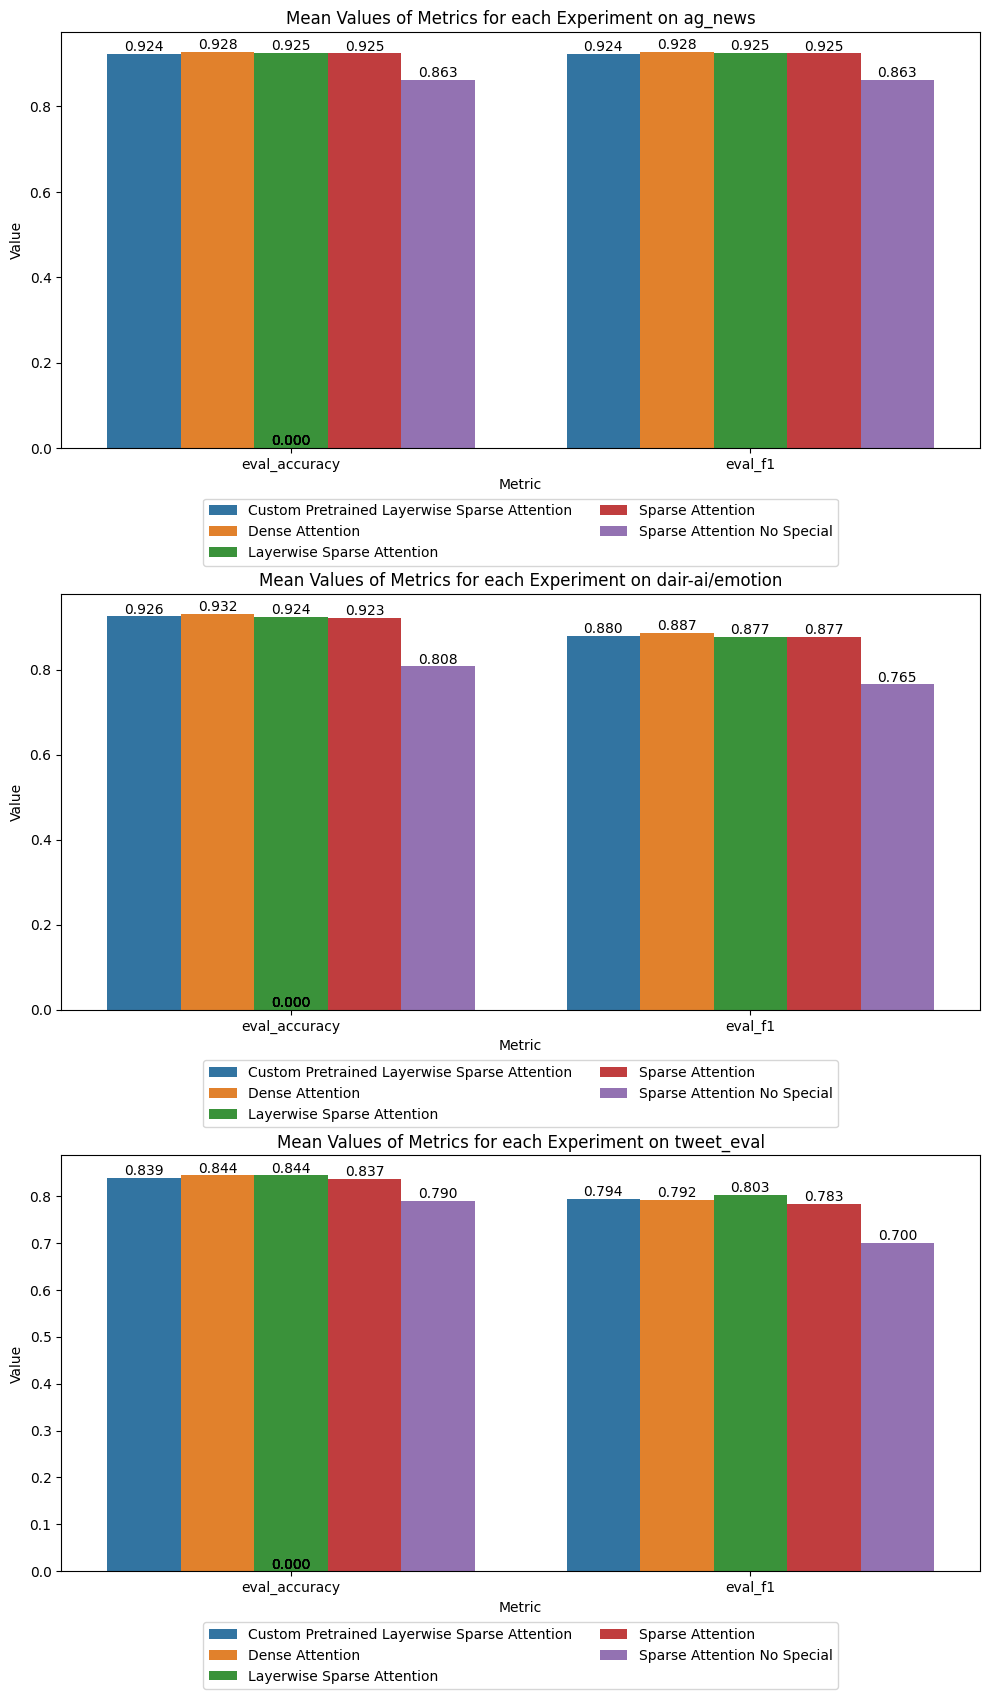

In [292]:
mean_df = all_results_df[["Experiment","Dataset","Metric","Value"]].groupby(["Experiment","Dataset", "Metric"]).mean().reset_index()
plot_results(mean_df)

In [278]:
from IPython.display import display
display(mean_df.style.background_gradient(cmap='viridis', subset=['Value']))

,Experiment,Dataset,Metric,Value
0,Custom Pretrained Layerwise Sparse Attention,ag_news,eval_accuracy,0.923842
1,Custom Pretrained Layerwise Sparse Attention,ag_news,eval_f1,0.924057
2,Custom Pretrained Layerwise Sparse Attention,dair-ai/emotion,eval_accuracy,0.925600
3,Custom Pretrained Layerwise Sparse Attention,dair-ai/emotion,eval_f1,0.879601
4,Custom Pretrained Layerwise Sparse Attention,tweet_eval,eval_accuracy,0.839070
5,Custom Pretrained Layerwise Sparse Attention,tweet_eval,eval_f1,0.794154
6,Dense Attention,ag_news,eval_accuracy,0.927763
7,Dense Attention,ag_news,eval_f1,0.927868
8,Dense Attention,dair-ai/emotion,eval_accuracy,0.932100
9,Dense Attention,dair-ai/emotion,eval_f1,0.887249


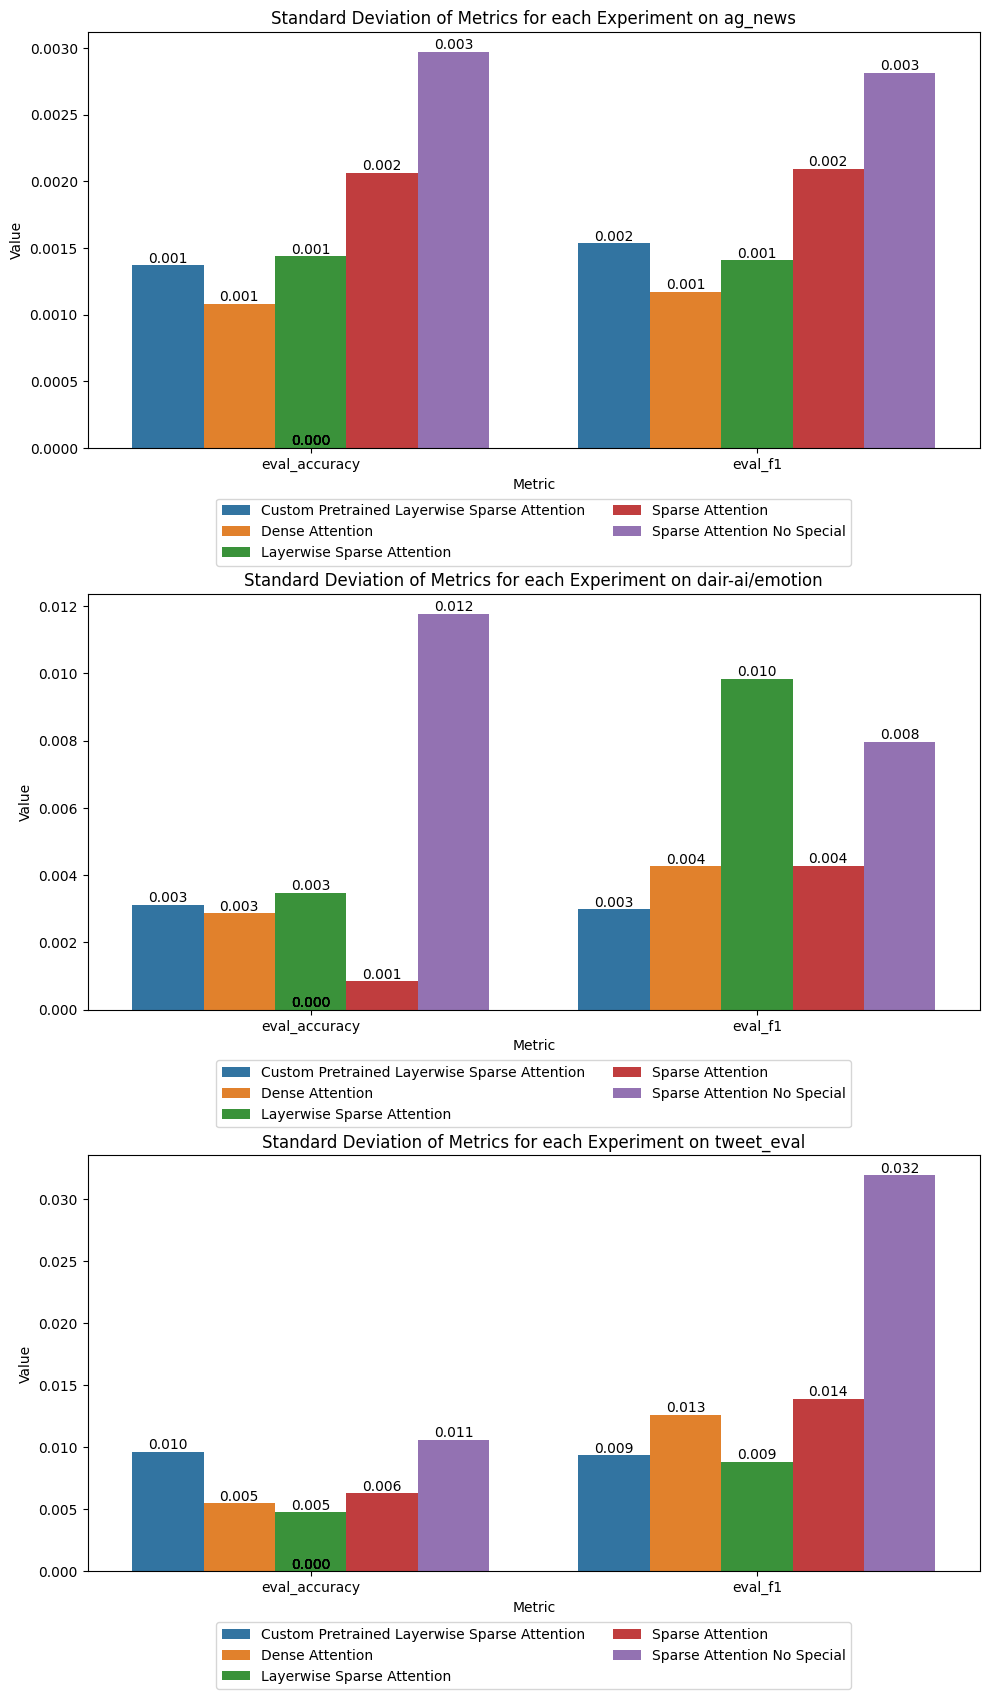

In [295]:
std_df = all_results_df[["Experiment","Dataset","Metric","Value"]].groupby(["Experiment","Dataset", "Metric"]).std().reset_index()
plot_results(std_df)